In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [9]:
import numpy as np
import torch
import falkon
import os, sys
sys.path.append("../benchmark")
import time
import matplotlib.pyplot as plt
import math
from libsvmdata import fetch_libsvm
import libsvmdata
from collections import defaultdict
from optimizing_centers_fns import *

In [10]:
import falkon
from falkon.hypergrad.complexity_reg import GPComplexityReg, SimpleFalkonComplexityReg, TrainableSGPR
from falkon.hypergrad.common import test_train_predict
from summary import get_writer
writer = get_writer("test")

## What to do here

 - Download SVMLight datasets
 - Run the SGPR with RBF kernel optimizing centers
 - Compare with the PCA centers
 
 
We use LessIsMore notation to express the different projected kernel-ridge problems.


We have that $Z_m$ is the projected feature-map. In the case of Nystrom uniform sampling it is the kernel feature-map $\phi$ applied to the chosen samples $\tilde{x}_i, \dots, \tilde{x}_m$.

The solution to the learning problem is
$$
\tilde{f}_m(x) = \sum_{i=1}^m \tilde{\alpha}_i z_i(x)
$$
where the coefficient vector is
$$
\tilde{\alpha} = (Z_m Z_n^\top Z_n Z_m^\top + \lambda n Z_m Z_m^\top)^\dagger Z_m Z_n^\top Y
$$

Let $K = Z_n Z_n^\top$ be the kernel matrix with eigendecomposition $K = \sum_{i=1}^n \sigma_i u_i u_i^\top$. By choosing $Z_m = U_m^\top Z_n$ we 

In [11]:
falkon_opt = falkon.FalkonOptions(keops_active="no", use_cpu=True)

### Short analysis of any given dataset to look for best sigma

In [11]:
dset_name = "space_ga"
X, y = fetch_libsvm(dset_name)
X = torch.from_numpy(np.asarray(X.todense())).float()
Y = torch.from_numpy(y.reshape(-1, 1)).float()
print(X.shape, Y.shape)
Xtr, Ytr, Xts, Yts = preprocess_dataset(X, Y, n_train=1000)

Dataset: space_ga

file_sizes: 100%|█████████████████████████████| 565k/565k [00:01<00:00, 379kB/s]
Successfully downloaded file to /home/giacomo/data/libsvm/regression/space_ga
Loading svmlight file...
torch.Size([3107, 6]) torch.Size([3107, 1])


In [12]:
penalty_init = torch.tensor(8., dtype=Xtr.dtype)
sigma_init = torch.tensor([dset_sigmas_15la[dset_name]], dtype=Xtr.dtype)
kernel = falkon.kernels.GaussianKernel(sigma_init, opt=falkon_opt)

In [13]:
print(krr_train_error(Xtr, Xts, Ytr, Yts, kernel, torch.exp(-penalty_init)))
print(krr_test_error(Xtr, Xts, Ytr, Yts, kernel, torch.exp(-penalty_init)))

0.0135438675
0.013704878


## Error vs. M plots.

We solve the learning problem in closed-form for different values of `M`. We compare the error obtained for different versions of the problem:

 1. Full kernel-ridge regression is the baseline, does not change with M.
 2. Nystrom KRR with uniformly chosen centers
 3. ~Nystrom KRR with random Gaussian centers
 4. ~Nystrom KRR with SVD centers

In [12]:
def get_svd_errs(m_list, la_list, err_type, Xtr, Xts, Ytr, Yts, kernel):
    if err_type == "train":
        get_err_fn = get_train_error
    else:
        get_err_fn = get_test_error
    
    svd_errs = defaultdict(list)
    for m in m_list:
        for la in la_list:
            Bnm, Gmm, Bnm_test = get_svd_bg(Xtr, m, kernel, Xts)
            svd_errs[la].append(get_err_fn(Bnm, Bnm_test, Gmm, Ytr, Yts, la))
        print(m, end=".")
    return svd_errs
def error_evolution(m_list, num_reps, err_type, Xtr, Xts, Ytr, Yts, kernel, la):
    if err_type == "train":
        krr_err_fn = krr_train_error
        get_err_fn = get_train_error
    else:
        krr_err_fn = krr_test_error
        get_err_fn = get_test_error
    
    Kfull = kernel(Xtr, Xtr)
    err_krr = krr_err_fn(Xtr, Xts, Ytr, Yts, kernel, la)

    err_random, err_nystrom, err_svd = [], [], []
    err_random_std, err_nystrom_std = [], []
    fro_random, fro_nystrom, fro_svd = [], [], []
    for m in m_list:
        errs = []
        for i in range(num_reps):
            Bnm, Gmm, Bnm_test = get_random_bg(Xtr, m, kernel, Xts)
            errs.append(get_err_fn(Bnm, Bnm_test, Gmm, Ytr, Yts, la))
        err_random.append(np.mean(errs))
        err_random_std.append(np.std(errs))

        errs = []
        for i in range(num_reps):
            Bnm, Gmm, Bnm_test = get_nystrom_bg(Xtr, m, kernel, Xts)
            errs.append(get_err_fn(Bnm, Bnm_test, Gmm, Ytr, Yts, la))
        err_nystrom.append(np.mean(errs))
        err_nystrom_std.append(np.std(errs))

        Bnm, Gmm, Bnm_test = get_svd_bg(Xtr, m, kernel, Xts)
        err_svd.append(get_err_fn(Bnm, Bnm_test, Gmm, Ytr, Yts, la))

        # Frobenius error to full kernel
        Bnm, Gmm, Bnm_test = get_random_bg(Xtr, m, kernel, Xts)
        Ktilde = Bnm @ torch.pinverse(Gmm) @ Bnm.T
        fro_random.append(torch.sum((Kfull - Ktilde)**2))

        Bnm, Gmm, Bnm_test = get_nystrom_bg(Xtr, m, kernel, Xts)
        Ktilde = Bnm @ torch.pinverse(Gmm) @ Bnm.T
        fro_nystrom.append(torch.sum((Kfull - Ktilde)**2))

        Bnm, Gmm, Bnm_test = get_svd_bg(Xtr, m, kernel, Xts)
        Ktilde = Bnm @ torch.pinverse(Gmm) @ Bnm.T
        fro_svd.append(torch.sum((Kfull - Ktilde)**2))
        print(m, end=".")
    return {
        "err_random": np.asarray(err_random),
        "err_nystrom": np.asarray(err_nystrom),
        "err_svd": np.asarray(err_svd),
        "err_random_std": np.asarray(err_random_std),
        "err_nystrom_std": np.asarray(err_nystrom_std),
        "fro_random": np.asarray(fro_random),
        "fro_nystrom": np.asarray(fro_nystrom),
        "fro_svd": np.asarray(fro_svd),
        "err_krr": err_krr
    }

In [13]:
def plot_error_evolution(m_list, data, err_type, figax=None, title=""):
    if figax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = figax
    ax1 = ax.twinx()
    # ax.plot(m_list, err_data["err_random"], label="random", color="#381642")
    # ax.fill_between(m_list, 
    #                 err_data["err_random"] - err_data["err_random_std"], 
    #                 err_data["err_random"] + err_data["err_random_std"],
    #                 color="#7f528c", alpha=0.2)
    # ax1.plot(m_list, err_data["fro_random"], color="#381642", linestyle="--", label="random")

    ax.plot(m_list, data["err_nystrom"], label="nystrom", color="#1a3f93")
    ax.fill_between(m_list, 
                    data["err_nystrom"] - data["err_nystrom_std"], 
                    data["err_nystrom"] + data["err_nystrom_std"],
                    color="#738bc4", alpha=0.2)
    ax1.plot(m_list, data["fro_nystrom"], color="#1a3f93", linestyle="--", label="nystrom")

    ax.plot(m_list, data["err_svd"], label="SVD", color="#366d0e")
    if "err_svd0" in data:
        ax.plot(m_list, data["err_svd0"], label="SVD($\lambda=0$)", color="k")
    if "err_svdhl" in data:
        ax.plot(m_list, data["err_svdhl"], label="SVD($\lambda = 10^{-3}$)", color="b")
    ax1.plot(m_list, data["fro_svd"], color="#366d0e", linestyle="--", label="SVD")

    ax.plot(m_list, [data["err_krr"].item()] * len(m_list), color="red", label="Full KRR")

    ax1.set_yscale("log")

    ax.legend(loc="best")
    ax.grid()

    ax.set_xlabel("M")
    ax.set_ylabel("%s MSE" % (err_type))
    ax1.set_ylabel("Frobenius norm to full kernel")
    ax.set_title(title)
    return fig, ax

### All-Dataset Plot

Dataset: cpusmall
torch.Size([8192, 12]) torch.Size([8192, 1])
1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.

/home/giacomo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


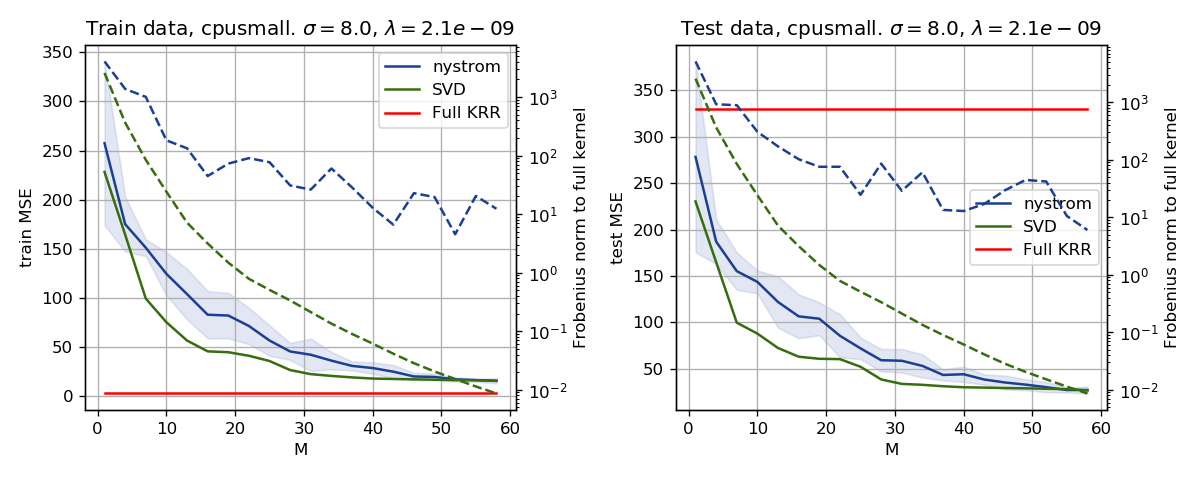

Dataset: abalone
torch.Size([4177, 8]) torch.Size([4177, 1])
1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.

/home/giacomo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


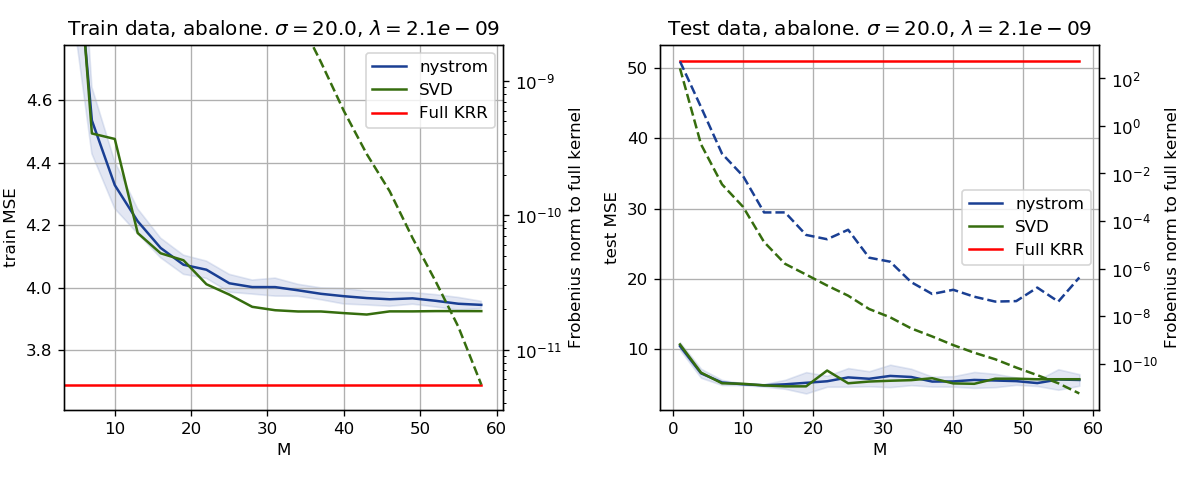

Dataset: space_ga
torch.Size([3107, 6]) torch.Size([3107, 1])
1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.

/home/giacomo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


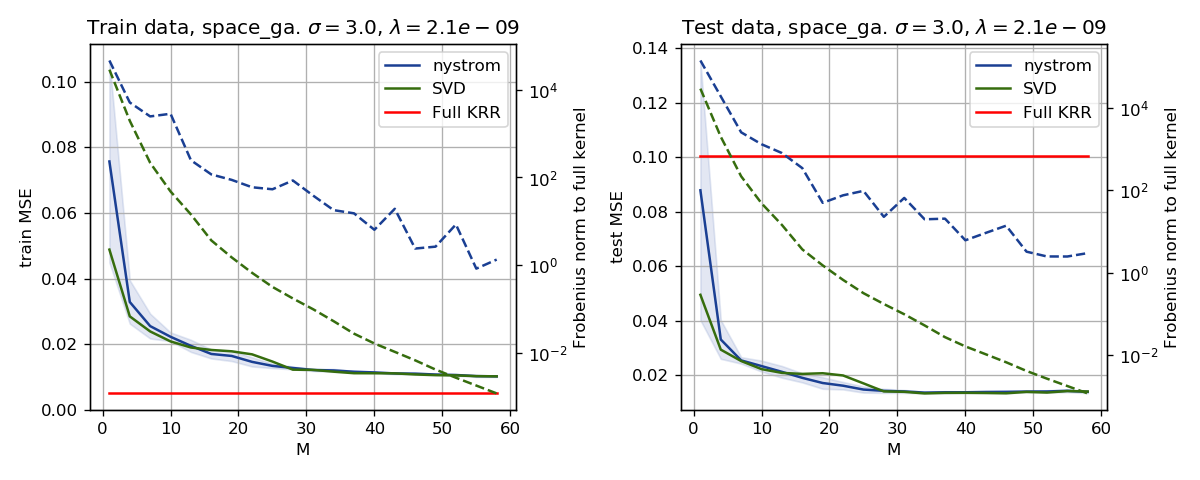

Dataset: svmguide1
torch.Size([3089, 4]) torch.Size([3089, 1])
1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.

/home/giacomo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


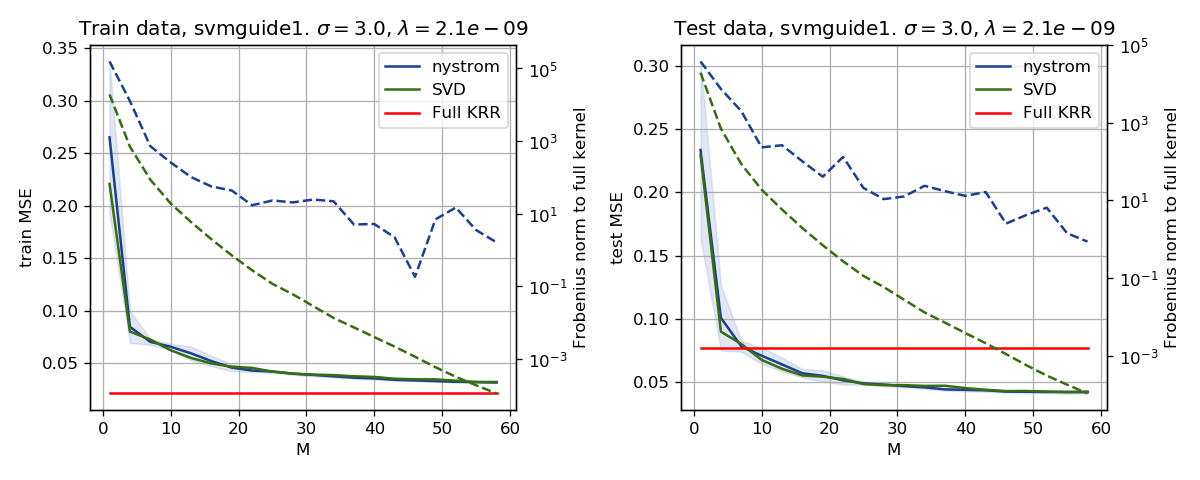

Dataset: cadata
torch.Size([20640, 8]) torch.Size([20640, 1])
1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.

/home/giacomo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


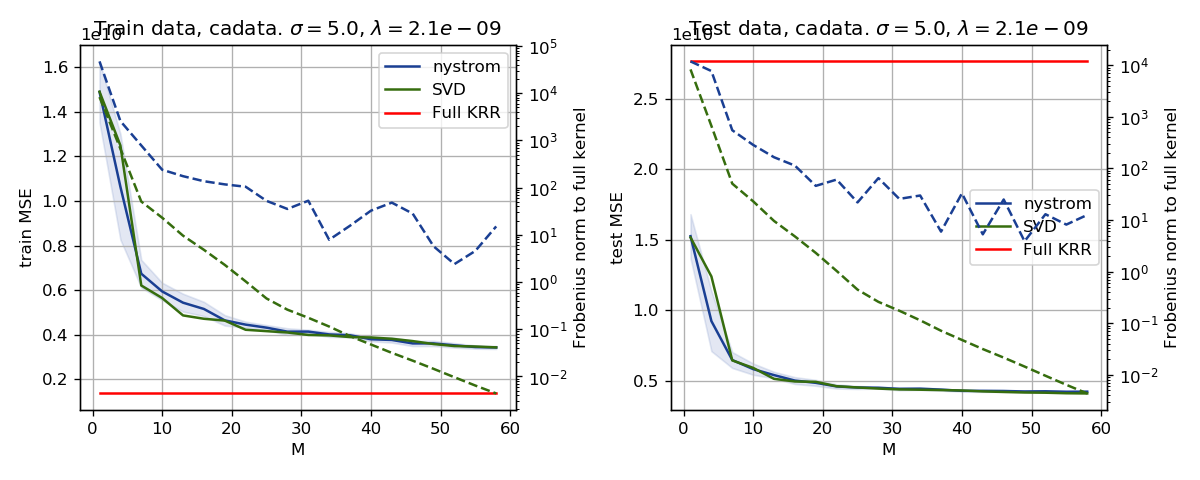

In [1680]:
for dset_name in dset_sigmas_15la.keys():
    Xtr, Ytr, Xts, Yts, penalty_init, sigma_init, kernel = load_dset(dset_name, penalty=20)
    m_list = list(range(1, 60, 3))
    train_err_data = error_evolution(m_list, 15, "train", Xtr, Xts, Ytr, Yts, kernel, torch.exp(-penalty_init))
    test_err_data = error_evolution(m_list, 15, "test", Xtr, Xts, Ytr, Yts, kernel, torch.exp(-penalty_init))
    fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
    title = "Train data, %s. $\sigma=%.1f$, $\lambda=%.1e$" % (
        dset_name, sigma_init.item(), torch.exp(-penalty_init).item())
    plot_error_evolution(m_list, train_err_data, "train", (fig, ax[0]), title)
    title = "Test data, %s. $\sigma=%.1f$, $\lambda=%.1e$" % (
        dset_name, sigma_init.item(), torch.exp(-penalty_init).item())
    plot_error_evolution(m_list, test_err_data, "test", (fig, ax[1]), title)
    fig.tight_layout()
    fig.savefig("/home/giacomo/Dropbox/unige/hyperopt/figures/%s_err_with_m_280420_v4.png" % (dset_name), dpi=400)

### SVD Solution with Different Lambdas

In [310]:
dset_name = "cpusmall"
Xtr, Ytr, Xts, Yts, penalty_init, sigma_init, kernel = load_dset(dset_name, penalty=15, dtype=torch.float64)

Dataset: cpusmall
torch.Size([8192, 12]) torch.Size([8192, 1])


In [354]:
m_list = np.arange(2, 50, 2)
la_list = np.logspace(-10, -2, 6)

train_err_data = error_evolution(m_list, 15, "train", Xtr, Xts, Ytr, Yts, kernel, torch.exp(-penalty_init))
train_svd_data = get_svd_errs(m_list, la_list, "train", Xtr, Xts, Ytr, Yts, kernel)
test_err_data = error_evolution(m_list, 15, "test", Xtr, Xts, Ytr, Yts, kernel, torch.exp(-penalty_init))
test_svd_data = get_svd_errs(m_list, la_list, "test", Xtr, Xts, Ytr, Yts, kernel)

2.4.6.8.10.12.14.16.18.20.22.24.26.28.30.32.34.36.38.40.42.44.46.48.2.4.6.8.10.12.14.16.18.20.22.24.26.28.30.32.34.36.38.40.42.44.46.48.

<IPython.core.display.Javascript object>


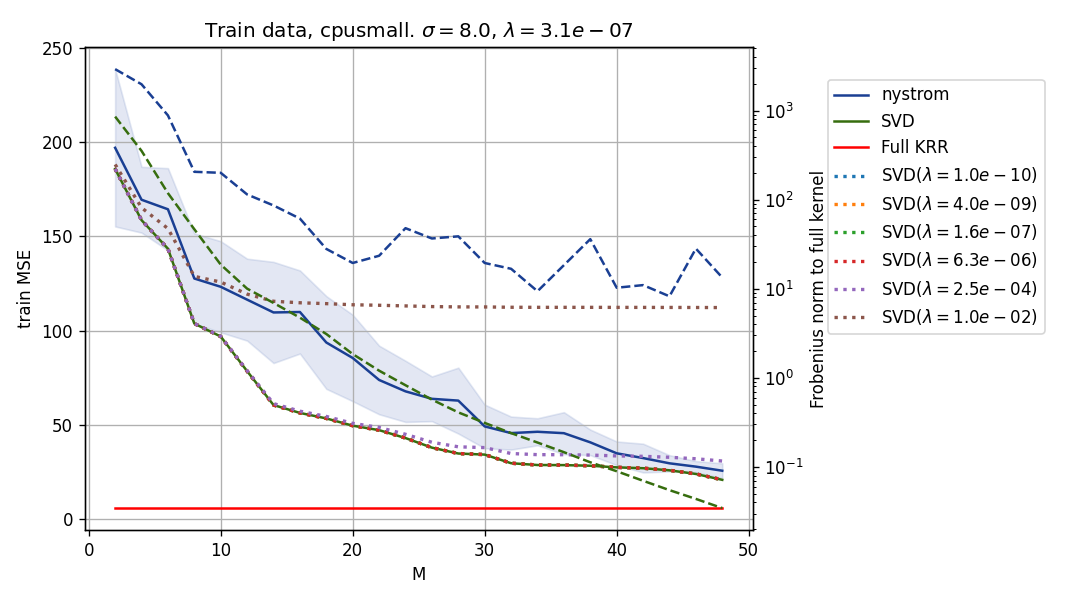

In [368]:
fig, ax = plt.subplots(figsize=(9, 5))
title = "Train data, %s. $\sigma=%.1f$, $\lambda=%.1e$" % (
    dset_name, sigma_init.item(), torch.exp(-penalty_init).item())
fig, ax = plot_error_evolution(m_list, train_err_data, "train", (fig, ax), title)
for l in train_svd_data.keys():
    ax.plot(m_list, train_svd_data[l], label="SVD($\lambda=%.1e$)" % (l), lw=2, linestyle=":")
ax.get_legend().remove()
ax.legend(bbox_to_anchor=(1.1, 0.95))
fig.tight_layout()

<IPython.core.display.Javascript object>


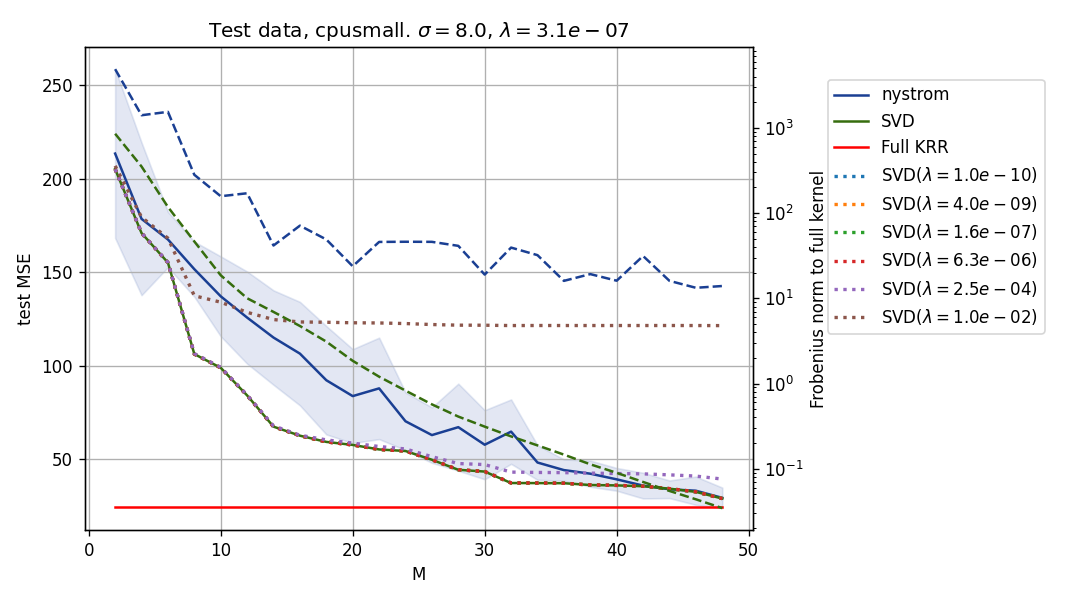

In [367]:
fig, ax = plt.subplots(figsize=(9, 5))
title = "Test data, %s. $\sigma=%.1f$, $\lambda=%.1e$" % (
    dset_name, sigma_init.item(), torch.exp(-penalty_init).item())
fig, ax = plot_error_evolution(m_list, test_err_data, "test", (fig, ax), title)
for l in test_svd_data.keys():
    ax.plot(m_list, test_svd_data[l], label="SVD($\lambda=%.1e$)" % (l), lw=2, linestyle=":")
ax.get_legend().remove()
ax.legend(bbox_to_anchor=(1.1, 0.95))
fig.tight_layout()

### Individual Dataset plots

<IPython.core.display.Javascript object>


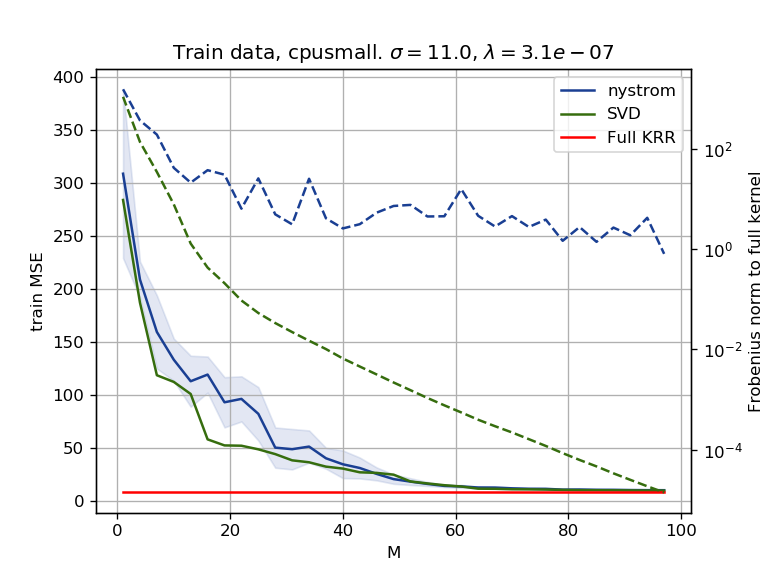

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe0ef32f910>)

In [1608]:
title = "Train data, %s. $\sigma=%.1f$, $\lambda=%.1e$" % (
    dset_name, sigma_init.item(), torch.exp(-penalty_init).item())
plot_error_evolution(m_list, train_err_data, "train", None, title)

<IPython.core.display.Javascript object>


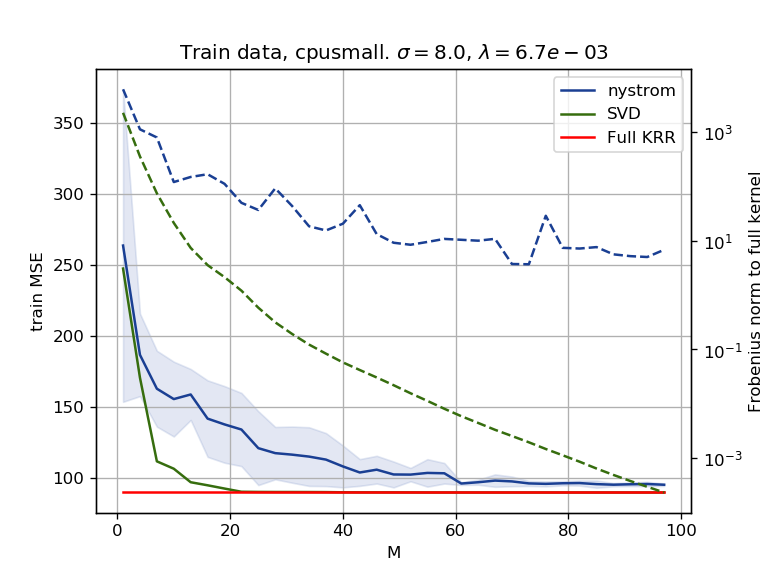

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe0ef57c250>)

In [1603]:
title = "Train data, %s. $\sigma=%.1f$, $\lambda=%.1e$" % (
    dset_name, sigma_init.item(), torch.exp(-penalty_init).item())
plot_error_evolution(m_list, train_err_data, "train", None, title)

<IPython.core.display.Javascript object>


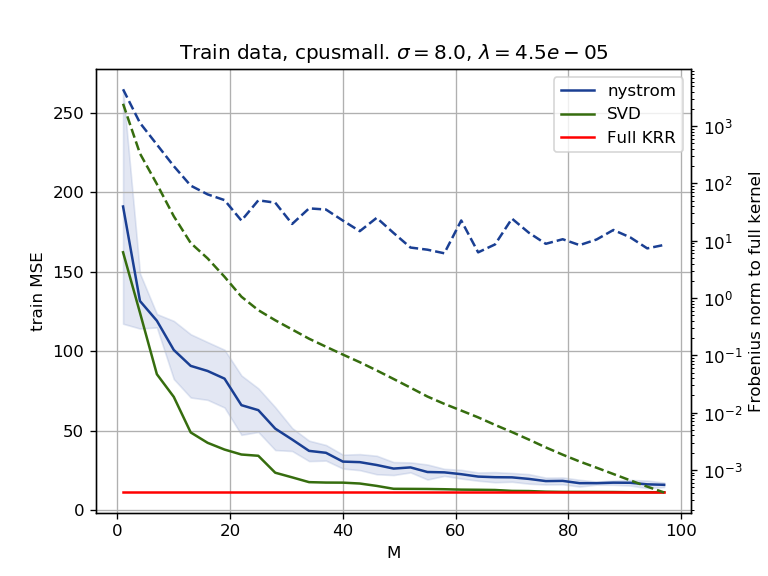

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe0ef5b3790>)

In [1600]:
title = "Train data, %s. $\sigma=%.1f$, $\lambda=%.1e$" % (
    dset_name, sigma_init.item(), torch.exp(-penalty_init).item())
plot_error_evolution(m_list, train_err_data, "train", None, title)

<IPython.core.display.Javascript object>


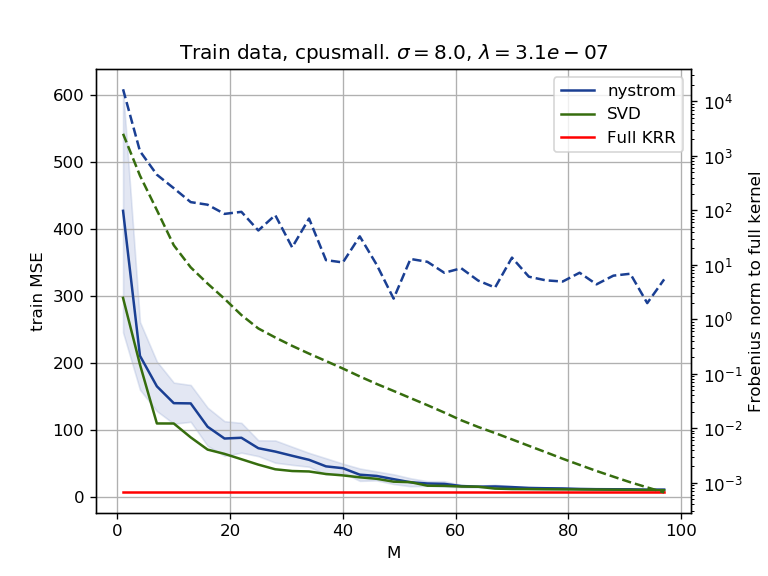

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe0ef898750>)

In [1597]:
title = "Train data, %s. $\sigma=%.1f$, $\lambda=%.1e$" % (
    dset_name, sigma_init.item(), torch.exp(-penalty_init).item())
plot_error_evolution(m_list, train_err_data, "train", None, title)

In [1469]:
test_err_data = error_evolution(m_list, 15, "test", Xtr, Xts, Ytr, Yts, kernel, torch.exp(-penalty_init))

1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.61.64.67.70.73.76.79.82.85.88.91.94.97.

<IPython.core.display.Javascript object>


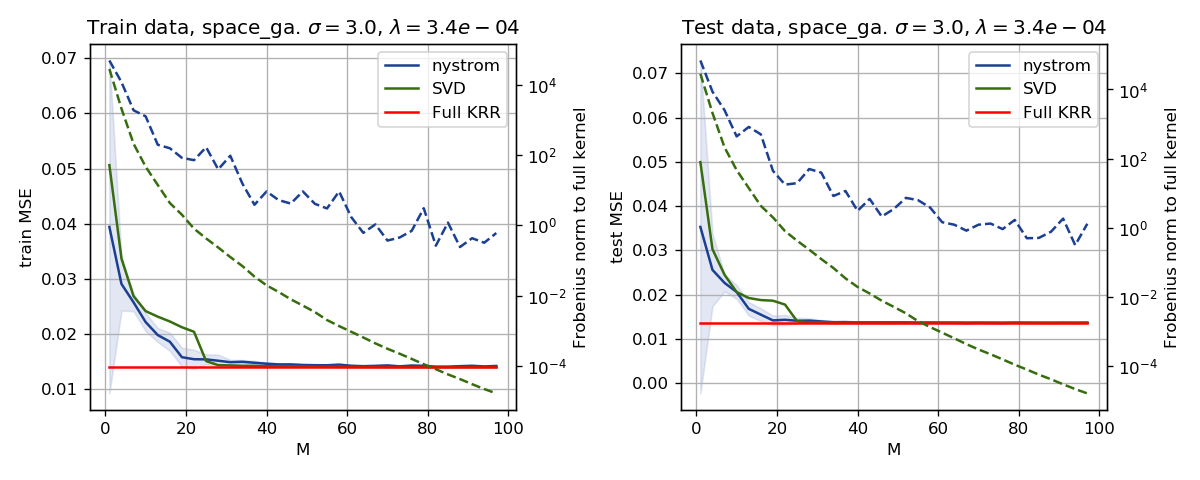

In [1476]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
title = "Train data, %s. $\sigma=%.1f$, $\lambda=%.1e$" % (
    dset_name, sigma_init.item(), torch.exp(-penalty_init).item())
plot_error_evolution(m_list, train_err_data, "train", (fig, ax[0]), title)
title = "Test data, %s. $\sigma=%.1f$, $\lambda=%.1e$" % (
    dset_name, sigma_init.item(), torch.exp(-penalty_init).item())
plot_error_evolution(m_list, test_err_data, "test", (fig, ax[1]), title)
fig.tight_layout()
fig.savefig("%s_err_with_m.png" % (dset_name), dpi=600)

## SGPR-like training plots

In [14]:
def train_gpflow_sgpr(penalty_init, sigma_init, centers_init, only_trace, 
                      lr, epochs, Xtr, Ytr, Xts, Yts, kernel):
    model = TrainableSGPR(sigma_init=sigma_init,
                          penalty_init=penalty_init,
                          centers_init=centers_init,
                          opt_centers=True,
                          opt_sigma=True,
                          opt_penalty=True,
                          num_epochs=epochs,
                          learning_rate=lr,
                          err_fn=mse)
    model.train(Xtr, Ytr, Xts, Yts)

In [15]:
def opt_plot(err_data, M, title, figax=None, legend=True):
    if figax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = figax
    num_epochs = len(err_data["tr_errs"])
    ax.plot(range(num_epochs), err_data["tr_errs"], label="Train MSE", color="#2f2f8c", lw=2)
    ax.plot(range(num_epochs), err_data["ts_errs"], label="Test MSE", color="#c67fb7", lw=2)

    ax1 = ax.twinx()
    ax1.plot(range(num_epochs), err_data["fro_errs"], color="#3b602a", 
             linestyle="--", label="Frobenius error", lw=2)


    ax.scatter(num_epochs + 2, err_data["tr_err_krr"], label="KRR(full) train MSE", 
               s=100, marker="*", color="#2f2f8c")
    ax.scatter(num_epochs + 2, err_data["ts_err_krr"], label="KRR(full) test MSE", 
               s=100, marker="*", color="#c67fb7")

    ax.scatter(num_epochs + 7, err_data["tr_err_svd"], label="SVD(%d) train MSE" % (M), 
               s=100, marker="o", color="#2f2f8c")
    ax.scatter(num_epochs + 7, err_data["ts_err_svd"], label="SVD(%d) test MSE" % (M), 
               s=100, marker="o", color="#c67fb7")


    if legend:
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax1.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, loc="best")

    ax.grid()
    ax.set_xlabel("Epoch")
    ax.set_ylabel("MSE")
    ax1.set_ylabel("Frobenius Error")
    ax1.set_yscale('log')
    ax.set_title(title)
    fig.tight_layout()
    return fig, ax
def get_title(model_name, M, train_only_trace, dset_name, sigma_init=None, penalty_init=None):
    title = "%s - %s - M=%d" % (dset_name, model_name, M)
    if train_only_trace:
        title += " - TRACE optimized"
    if sigma_init is not None:
        title += " - $\sigma=%.1f$" % (sigma_init.item())
    if penalty_init is not None:
        title += " - $\lambda=%.2e$" % (penalty_init.item())
    return title

In [54]:
M = 100
train_only_trace = True
learning_rate = 0.1
only_trace_100 = {}
for dset_name in ["cpusmall", "space_ga"]:
    Xtr, Ytr, Xts, Yts, penalty_init, sigma_init, kernel = load_dset(dset_name, penalty=15)
    centers_init = torch.randn(M, Xtr.shape[1], dtype=Xtr.dtype)
    res_flk = train_sgpr_like(opt_model="Falkon", penalty_init=penalty_init, sigma_init=sigma_init, 
                              centers_init=centers_init, only_trace=train_only_trace, lr=learning_rate, 
                              epochs=num_epochs, Xtr=Xtr, Ytr=Ytr, Xts=Xts, Yts=Yts, kernel=kernel)
    only_trace_100[dset_name] = res_flk

Dataset: cpusmall
torch.Size([8192, 12]) torch.Size([8192, 1])
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -2.00240e+04
Epoch 0 ( 2.69s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 215.3927 - Ts  mse = 489.9392
Fro err: 10.344
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -1.70992e+04
Epoch 1 ( 5.74s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 128.5841 - Ts  mse = 402.5931
Fro err: 9.132
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -1.56763e+04
Epoch 2 ( 8.65s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 98.9849 - Ts  mse = 333.7506
Fro err: 8.325
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -1.47039e+04
Epoch 3 (11.06s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 78.1040 - Ts  mse = 281.5144
Fro err: 7.642
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -1.39037e+04
Epoch 4 (13.50s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 62.1906 - Ts  mse = 243.5924
Fro err: 7.008
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00

Epoch 46 (103.23s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 10.3763 - Ts  mse = 26.4244
Fro err: 0.553
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -2.96846e+03
Epoch 47 (105.25s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 10.3297 - Ts  mse = 25.9322
Fro err: 0.556
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -2.95578e+03
Epoch 48 (106.98s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 10.3271 - Ts  mse = 25.9280
Fro err: 0.475
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -2.79775e+03
Epoch 49 (108.52s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 10.2608 - Ts  mse = 25.4456
Fro err: 0.475
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -2.77372e+03
Epoch 50 (110.14s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 10.1291 - Ts  mse = 24.9153
Fro err: 0.448
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -2.69847e+03
Epoch 51 (111.69s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 10.0160 - Ts  mse = 24.3983
Fro err: 0.413
VAL

Fro err: 0.040
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -1.10780e+03
Epoch 93 (168.35s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 9.5143 - Ts  mse = 31.2610
Fro err: 0.040
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -1.09753e+03
Epoch 94 (169.74s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 9.6337 - Ts  mse = 31.4951
Fro err: 0.042
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -1.09886e+03
Epoch 95 (170.97s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 9.5683 - Ts  mse = 31.0921
Fro err: 0.032
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -1.04443e+03
Epoch 96 (172.19s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 9.6062 - Ts  mse = 33.9447
Fro err: 0.034
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -1.04674e+03
Epoch 97 (173.27s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 9.7930 - Ts  mse = 32.2067
Fro err: 0.037
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -1.04800e+03
Epoch 98 (174.32s) - Sigma 8.

Epoch 39 (52.99s) - Sigma 3.000 - Penalty 3.06e-07 - Tr  mse = 0.0093 - Ts  mse = 0.0126
Fro err: 0.004
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -5.07570e+02
Epoch 40 (54.07s) - Sigma 3.000 - Penalty 3.06e-07 - Tr  mse = 0.0093 - Ts  mse = 0.0127
Fro err: 0.003
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -4.88993e+02
Epoch 41 (55.22s) - Sigma 3.000 - Penalty 3.06e-07 - Tr  mse = 0.0093 - Ts  mse = 0.0127
Fro err: 0.003
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -4.70479e+02
Epoch 42 (56.40s) - Sigma 3.000 - Penalty 3.06e-07 - Tr  mse = 0.0092 - Ts  mse = 0.0127
Fro err: 0.003
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -4.51545e+02
Epoch 43 (57.45s) - Sigma 3.000 - Penalty 3.06e-07 - Tr  mse = 0.0092 - Ts  mse = 0.0129
Fro err: 0.003
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -4.34507e+02
Epoch 44 (58.47s) - Sigma 3.000 - Penalty 3.06e-07 - Tr  mse = 0.0092 - Ts  mse = 0.0129
Fro err: 0.002
VALUE        d_eff 0.

Epoch 86 (112.90s) - Sigma 3.000 - Penalty 3.06e-07 - Tr  mse = 0.0088 - Ts  mse = 0.0120
Fro err: 0.000
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -1.84105e+02
Epoch 87 (114.22s) - Sigma 3.000 - Penalty 3.06e-07 - Tr  mse = 0.0088 - Ts  mse = 0.0120
Fro err: 0.000
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -1.82407e+02
Epoch 88 (115.77s) - Sigma 3.000 - Penalty 3.06e-07 - Tr  mse = 0.0088 - Ts  mse = 0.0119
Fro err: 0.000
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -1.80739e+02
Epoch 89 (116.78s) - Sigma 3.000 - Penalty 3.06e-07 - Tr  mse = 0.0088 - Ts  mse = 0.0119
Fro err: 0.000
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -1.79172e+02
Epoch 90 (117.95s) - Sigma 3.000 - Penalty 3.06e-07 - Tr  mse = 0.0088 - Ts  mse = 0.0120
Fro err: 0.000
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -1.77684e+02
Epoch 91 (119.30s) - Sigma 3.000 - Penalty 3.06e-07 - Tr  mse = 0.0088 - Ts  mse = 0.0120
Fro err: 0.000
VALUE        d_

<IPython.core.display.Javascript object>


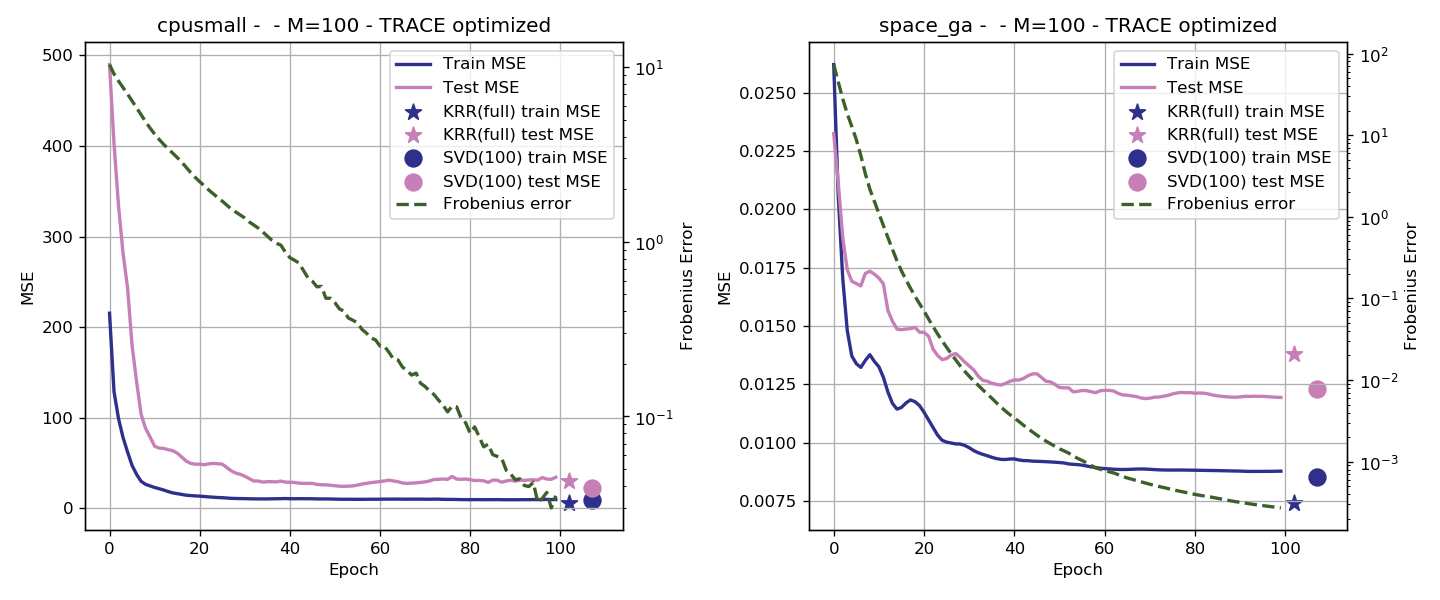

In [56]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
for i, (dset_name, data) in enumerate(only_trace_100.items()):
    title = get_title("", 100, True, dset_name)
    opt_plot(data, 100, title, figax=(fig, ax[i]))

In [ ]:
M = 100
train_only_trace = False
learning_rate = 0.1
num_epochs = 20
results_100_flk = {}
results_100_sgpr = {}
for dset_name in ["cpusmall", "space_ga"]:
    Xtr, Ytr, Xts, Yts, penalty_init, sigma_init, kernel = load_dset(dset_name, penalty=15)
    centers_init = torch.randn(M, Xtr.shape[1], dtype=Xtr.dtype)
    res_flk = train_sgpr_like(opt_model="Falkon", penalty_init=penalty_init, sigma_init=sigma_init,
                              centers_init=centers_init, only_trace=train_only_trace, lr=learning_rate,
                              epochs=num_epochs, Xtr=Xtr, Ytr=Ytr, Xts=Xts, Yts=Yts, kernel=kernel)
    res_sgpr = train_sgpr_like(opt_model="SGPR", penalty_init=penalty_init, sigma_init=sigma_init,
                               centers_init=centers_init, only_trace=train_only_trace, lr=learning_rate,
                               epochs=num_epochs, Xtr=Xtr, Ytr=Ytr, Xts=Xts, Yts=Yts, kernel=kernel)
    results_100_flk[dset_name] = res_flk
    results_100_sgpr[dset_name]= res_sgpr

Dataset: cpusmall
torch.Size([8192, 12]) torch.Size([8192, 1])
VALUE        d_eff -3.01089e+05 - loss -3.96653e+07 - trace -2.07880e+04
Epoch 0 ( 1.56s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 213.8287 - Ts  mse = 501.5016
Fro err: 16.146
VALUE        d_eff -3.01827e+05 - loss -3.58626e+07 - trace -2.07464e+04
Epoch 1 ( 3.24s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 116.4996 - Ts  mse = 296.7578
Fro err: 16.272
VALUE        d_eff -3.01965e+05 - loss -3.42083e+07 - trace -2.09134e+04
Epoch 2 ( 4.56s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 80.9815 - Ts  mse = 255.2180
Fro err: 15.951
VALUE        d_eff -3.02031e+05 - loss -3.28677e+07 - trace -2.08092e+04
Epoch 3 ( 5.64s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 59.4460 - Ts  mse = 215.4174
Fro err: 15.713
VALUE        d_eff -3.02230e+05 - loss -3.12838e+07 - trace -2.07726e+04
Epoch 4 ( 6.81s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 45.9063 - Ts  mse = 179.1606
Fro err: 15.606
VALUE        d_eff -3.02588e+05 - l

Epoch 45 (60.64s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 7.8574 - Ts  mse = 26.0746
Fro err: 11.573
VALUE        d_eff -3.04616e+05 - loss -2.37450e+07 - trace -1.89789e+04
Epoch 46 (61.78s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 7.8698 - Ts  mse = 26.0093
Fro err: 11.500
VALUE        d_eff -3.04706e+05 - loss -2.37022e+07 - trace -1.89201e+04
Epoch 47 (63.08s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 7.7559 - Ts  mse = 25.6326
Fro err: 11.452
VALUE        d_eff -3.04838e+05 - loss -2.35617e+07 - trace -1.88697e+04
Epoch 48 (64.61s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 7.6723 - Ts  mse = 25.2841
Fro err: 11.411
VALUE        d_eff -3.04943e+05 - loss -2.35977e+07 - trace -1.88242e+04
Epoch 49 (66.12s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 7.6059 - Ts  mse = 25.1409
Fro err: 11.353
VALUE        d_eff -3.05073e+05 - loss -2.35150e+07 - trace -1.87686e+04
Epoch 50 (67.78s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 7.5746 - Ts  mse = 25.0093
Fro err: 11.291

Epoch 91 (127.36s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 6.6321 - Ts  mse = 22.6281
Fro err: 9.704
VALUE        d_eff -3.07439e+05 - loss -2.31354e+07 - trace -1.71191e+04
Epoch 92 (128.72s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 6.6818 - Ts  mse = 22.9891
Fro err: 9.694
VALUE        d_eff -3.07410e+05 - loss -2.31623e+07 - trace -1.70860e+04
Epoch 93 (129.95s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 6.6266 - Ts  mse = 22.2976
Fro err: 9.616
VALUE        d_eff -3.07520e+05 - loss -2.30987e+07 - trace -1.70295e+04
Epoch 94 (131.27s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 6.6143 - Ts  mse = 22.7475
Fro err: 9.588
VALUE        d_eff -3.07591e+05 - loss -2.30441e+07 - trace -1.69944e+04
Epoch 95 (133.37s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 6.6020 - Ts  mse = 22.5569
Fro err: 9.573
VALUE        d_eff -3.07550e+05 - loss -2.30950e+07 - trace -1.69670e+04
Epoch 96 (136.15s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 6.5936 - Ts  mse = 22.6591
Fro err: 9.534

Epoch 37 (49.91s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 8.4988 - Ts  mse = 28.6569
Fro err: 11.981
VALUE        d_eff 3.80652e+03 - loss -1.19234e+07 - trace -1.93677e+04
Epoch 38 (50.99s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 8.3535 - Ts  mse = 28.4853
Fro err: 11.952
VALUE        d_eff 3.80652e+03 - loss -1.19067e+07 - trace -1.93477e+04
Epoch 39 (52.02s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 8.2681 - Ts  mse = 27.7571
Fro err: 11.920
VALUE        d_eff 3.80650e+03 - loss -1.18896e+07 - trace -1.93219e+04
Epoch 40 (53.06s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 8.1675 - Ts  mse = 27.4143
Fro err: 11.884
VALUE        d_eff 3.80648e+03 - loss -1.18729e+07 - trace -1.92932e+04
Epoch 41 (54.09s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 8.1183 - Ts  mse = 27.2007
Fro err: 11.852
VALUE        d_eff 3.80647e+03 - loss -1.18599e+07 - trace -1.92683e+04
Epoch 42 (55.30s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 8.0487 - Ts  mse = 26.6539
Fro err: 11.818
VALU

Epoch 83 (119.87s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 6.6626 - Ts  mse = 23.0653
Fro err: 9.976
VALUE        d_eff 3.80318e+03 - loss -1.15541e+07 - trace -1.74371e+04
Epoch 84 (121.04s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 6.6776 - Ts  mse = 22.7186
Fro err: 9.940
VALUE        d_eff 3.80310e+03 - loss -1.15773e+07 - trace -1.73975e+04
Epoch 85 (122.13s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 6.7971 - Ts  mse = 23.2726
Fro err: 9.897
VALUE        d_eff 3.80304e+03 - loss -1.16271e+07 - trace -1.73555e+04
Epoch 86 (123.32s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 6.7982 - Ts  mse = 22.6608
Fro err: 9.862
VALUE        d_eff 3.80288e+03 - loss -1.16465e+07 - trace -1.73106e+04
Epoch 87 (124.55s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 6.6940 - Ts  mse = 22.6664
Fro err: 9.823
VALUE        d_eff 3.80279e+03 - loss -1.15367e+07 - trace -1.72750e+04
Epoch 88 (125.73s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 6.7867 - Ts  mse = 23.2557
Fro err: 9.802
VALU

<IPython.core.display.Javascript object>


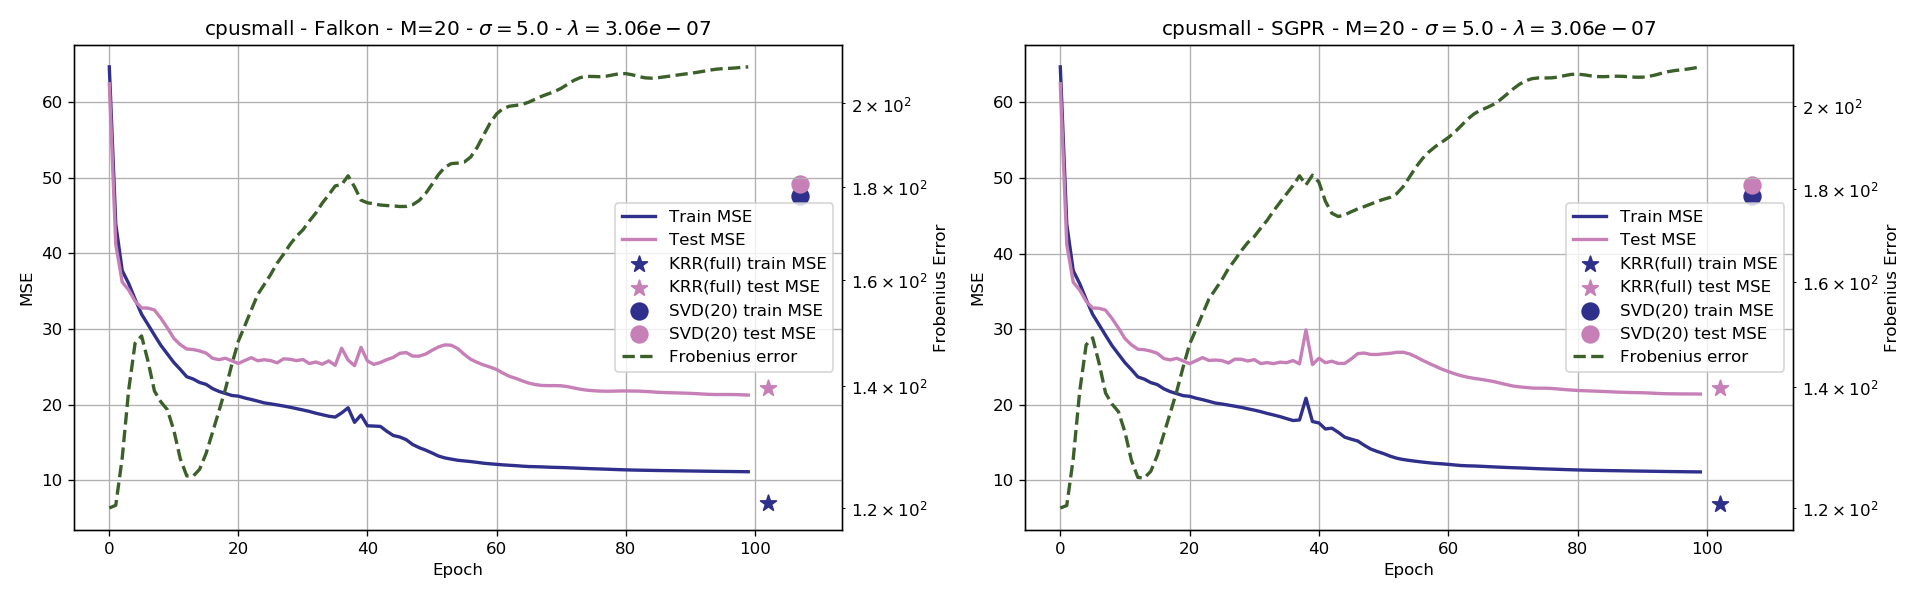

<IPython.core.display.Javascript object>


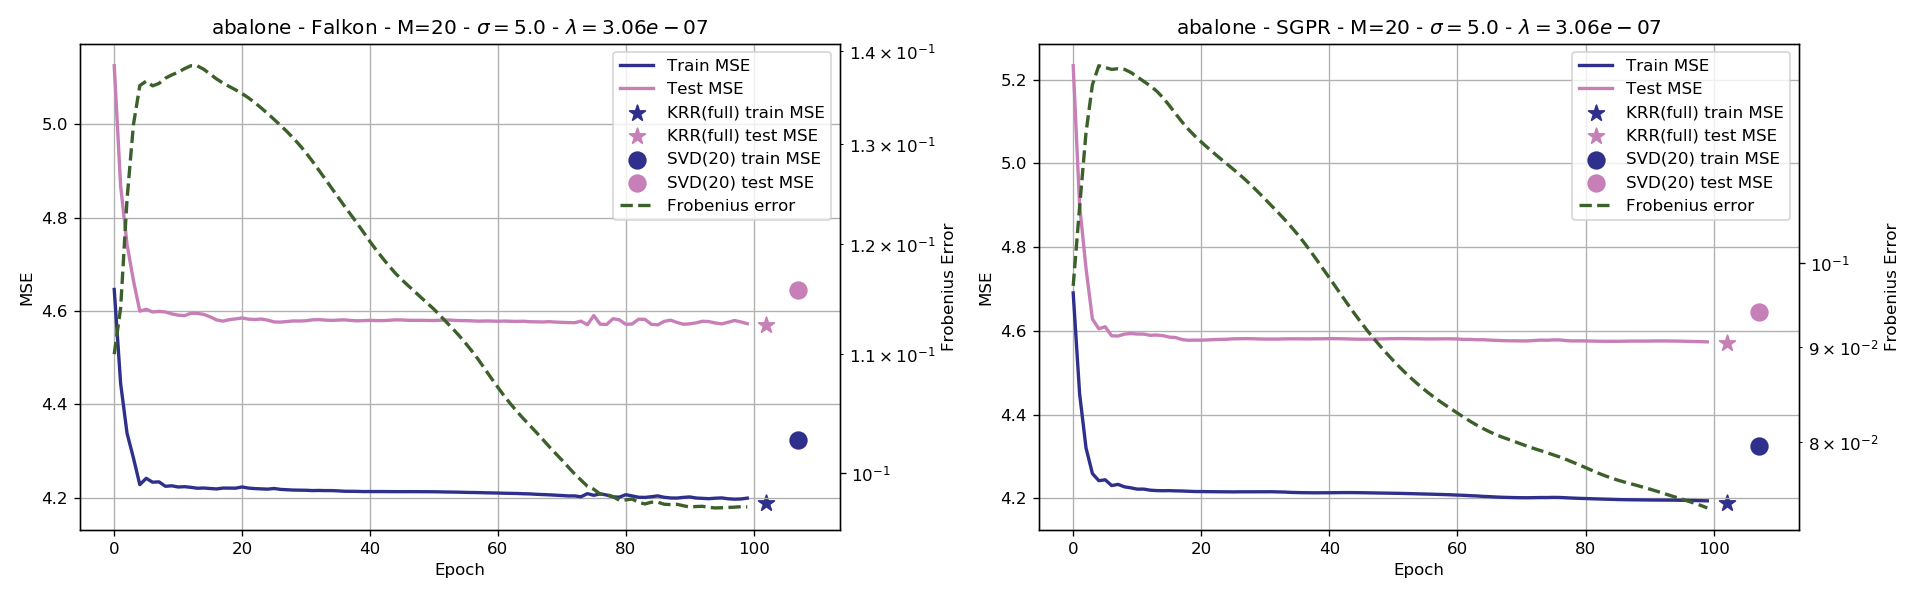

<IPython.core.display.Javascript object>


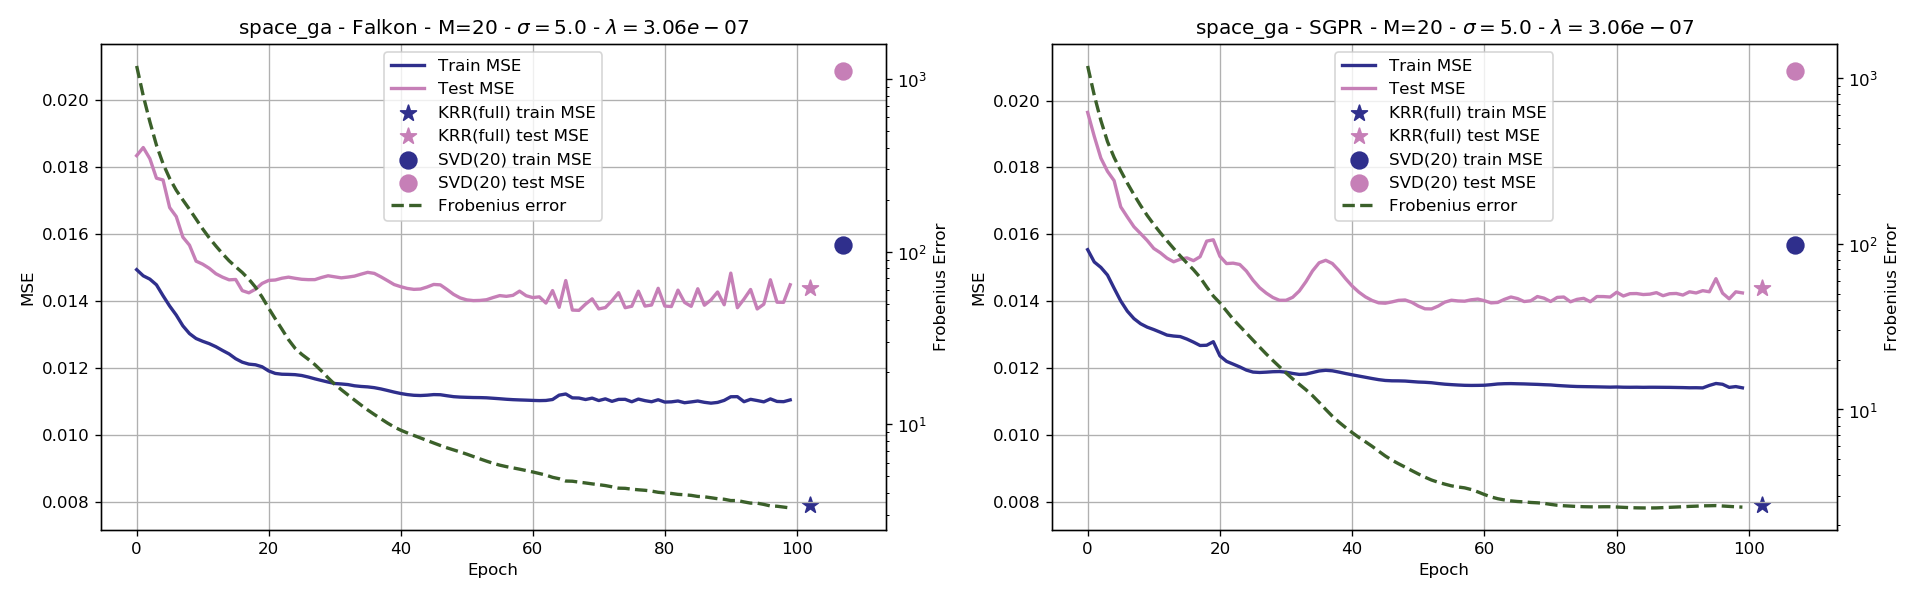

<IPython.core.display.Javascript object>


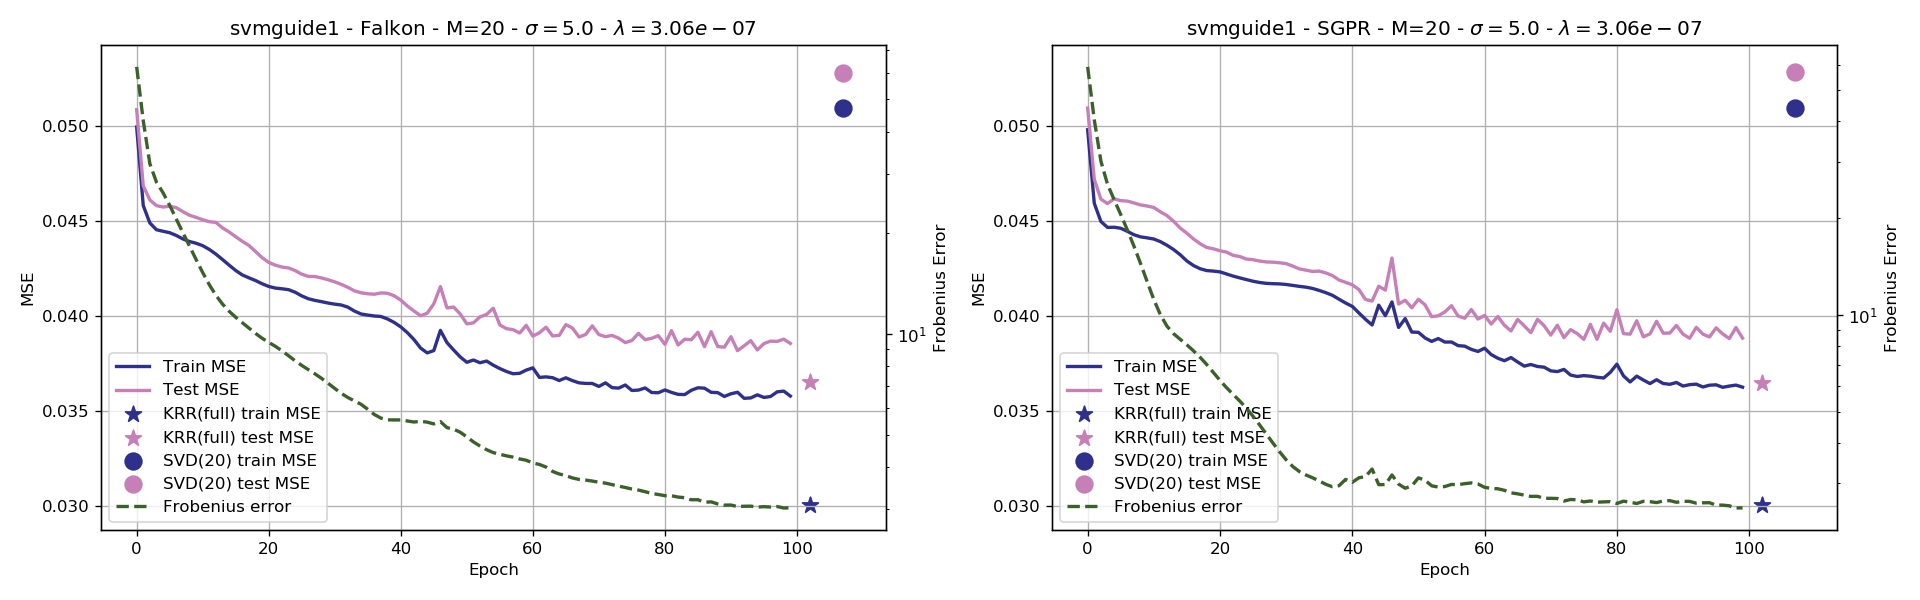

<IPython.core.display.Javascript object>


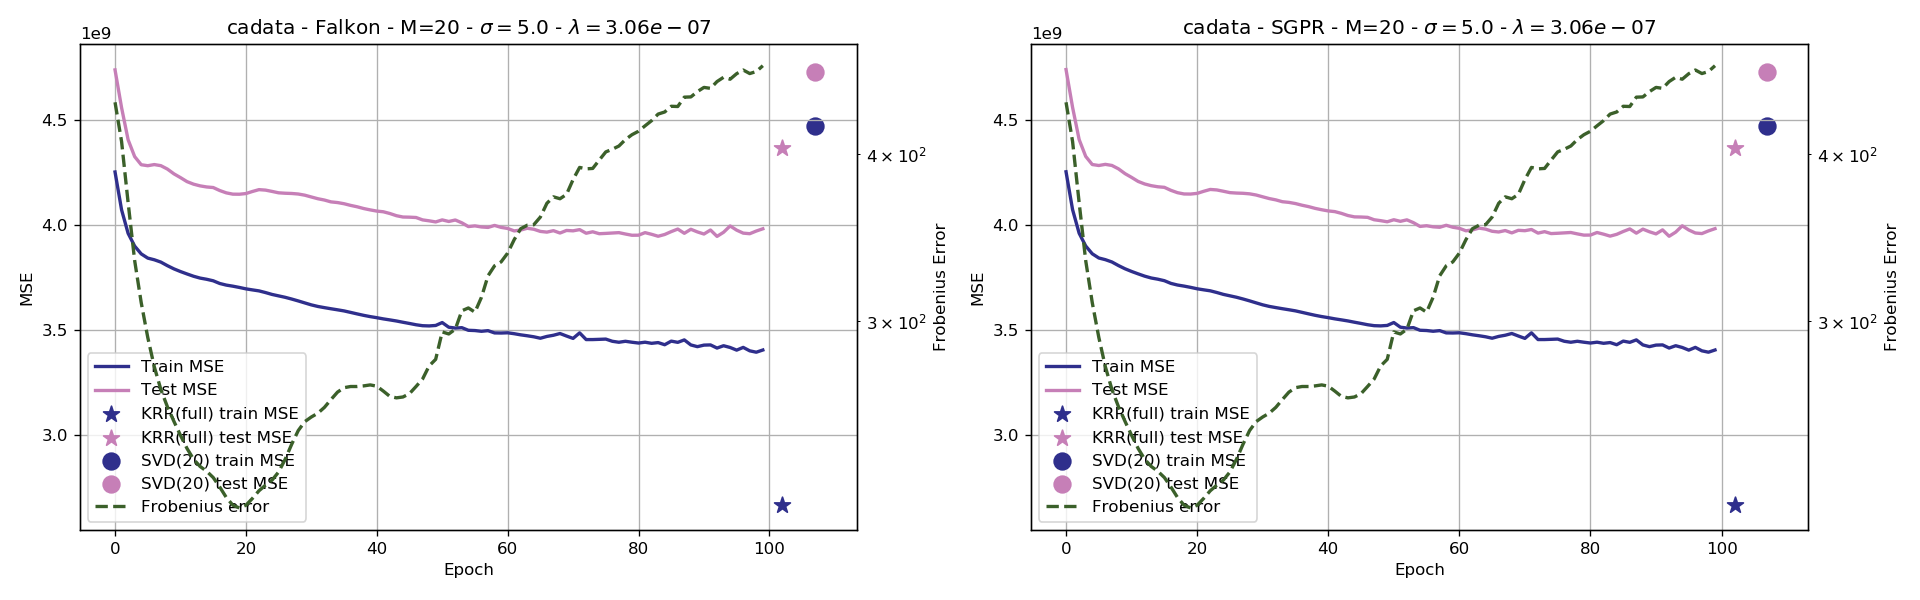

In [50]:
for dset_name in dset_sigmas_15la.keys():
    fig, ax = plt.subplots(ncols=2, figsize=(16, 5))
    title = get_title("Falkon", 20, False, dset_name, sigma_init=sigma_init, penalty_init=torch.exp(-penalty_init))
    opt_plot(results_20_flk[dset_name], 20, title, figax=(fig, ax[0]))
    title = get_title("SGPR", 20, False, dset_name, sigma_init=sigma_init, penalty_init=torch.exp(-penalty_init))
    opt_plot(results_20_sgpr[dset_name], 20, title, figax=(fig, ax[1]))
    fig.tight_layout()
    fig.savefig("figures/opt_290420_M20_%s_v1.png" % (dset_name))

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
title = get_title("Falkon", M, train_only_trace, dset_name)
opt_plot(res_flk, M, title, figax=(fig, ax[0]))
title = get_title("SGPR", M, train_only_trace, dset_name)
opt_plot(res_sgpr, M, title, figax=(fig, ax[1]))
fig.tight_layout();

In [17]:
dset_name = "cpusmall"
Xtr, Ytr, Xts, Yts, penalty_init, sigma_init, kernel = load_dset(dset_name, penalty=15, dtype=torch.float64)
print(Xtr.dtype)
M = 100
torch.manual_seed(82)
centers_init = torch.randn(M, Xtr.shape[1], dtype=Xtr.dtype)
learning_rate = 0.1
num_epochs = 30
train_only_trace = False

Dataset: cpusmall
torch.Size([8192, 12]) torch.Size([8192, 1])
torch.float64


In [35]:
res_sgpr = train_gpflow_sgpr(
    penalty_init=torch.tensor(1e-5), sigma_init=sigma_init, 
    centers_init=centers_init, only_trace=train_only_trace, lr=learning_rate*1, 
    epochs=num_epochs, Xtr=Xtr, Ytr=Ytr, Xts=Xts, Yts=Yts, kernel=kernel)

╒══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═══════════╤═════════╤════════════════════════════════════════════╕
│ name                     │ class     │ transform        │ prior   │ trainable   │ shape     │ dtype   │ value                                      │
╞══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═══════════╪═════════╪════════════════════════════════════════════╡
│ SGPR.kernel.variance     │ Parameter │ Softplus         │         │ False       │ ()        │ float64 │ 1.0                                        │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────┼─────────┼────────────────────────────────────────────┤
│ SGPR.kernel.lengthscales │ Parameter │ Identity         │         │ True        │ ()        │ float64 │ 8.0                                        │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────

trace -57508.130712994374
tot -65547284.0085024
variance in predict 6.3583824862225552e-05
variance in predict 6.3583824862225552e-05
Epoch 28 - train nrmse = 0.0321 - test nrmse 0.0743
logdet 4555.0078470894241
datafit -63072573.033233643
trace -55156.466015021317
tot -63124093.42993477
variance in predict 6.5980734018122883e-05
variance in predict 6.5980734018122883e-05
Epoch 29 - train nrmse = 0.0320 - test nrmse 0.0738
logdet 4538.4449339552357
datafit -60817081.050834656
trace -52996.348423255607
tot -60866457.892857157
variance in predict 6.8378958569590621e-05
variance in predict 6.8378958569590621e-05
Epoch 30 - train nrmse = 0.0320 - test nrmse 0.0736
╒══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═══════════╤═════════╤════════════════════════════════════════════╕
│ name                     │ class     │ transform        │ prior   │ trainable   │ shape     │ dtype   │ value                                      │
╞══════════════════════════╪═

In [32]:
res_sgpr = train_sgpr_like(opt_model="SGPR", penalty_init=torch.tensor(1e-5),#torch.exp(-penalty_init),# * Xtr.shape[0], 
                           sigma_init=sigma_init,
                           centers_init=centers_init, only_trace=train_only_trace, lr=learning_rate*1, 
                           epochs=num_epochs, Xtr=Xtr, Ytr=Ytr, Xts=Xts, Yts=Yts, kernel=kernel)

VALUE        d_eff 5.364e+03 - loss -8.434e+08 - trace -6.151e+05. tot -8.440e+08
VALUE        d_eff 1.108e+03 - loss -2.399e+05 - trace -9.780e+02. tot -2.398e+05
Epoch 0 ( 0.51s) - Sigma 8.100 - Penalty 1.00e-01 - Tr  nrmse = 0.0683 - Ts  nrmse = 0.0612
Fro err: 3.357
VALUE        d_eff 1.108e+03 - loss -2.399e+05 - trace -9.780e+02. tot -2.398e+05
VALUE        d_eff 8.592e+02 - loss -1.699e+05 - trace -9.535e+02. tot -1.700e+05
Epoch 1 ( 1.16s) - Sigma 8.167 - Penalty 1.67e-01 - Tr  nrmse = 0.0744 - Ts  nrmse = 0.0668
Fro err: 3.285
VALUE        d_eff 8.592e+02 - loss -1.699e+05 - trace -9.535e+02. tot -1.700e+05
VALUE        d_eff 7.278e+02 - loss -1.418e+05 - trace -9.450e+02. tot -1.420e+05
Epoch 2 ( 1.66s) - Sigma 8.219 - Penalty 2.19e-01 - Tr  nrmse = 0.0781 - Ts  nrmse = 0.0705
Fro err: 3.248
VALUE        d_eff 7.278e+02 - loss -1.418e+05 - trace -9.450e+02. tot -1.420e+05
VALUE        d_eff 6.415e+02 - loss -1.260e+05 - trace -9.406e+02. tot -1.263e+05
Epoch 3 ( 2.22s) - Sigm

KeyboardInterrupt: 

In [34]:
res_sgpr = train_sgpr_like(opt_model="SGPR", penalty_init=torch.tensor(1e-5),#torch.exp(-penalty_init),# * Xtr.shape[0], 
                           sigma_init=sigma_init,
                           centers_init=centers_init, only_trace=train_only_trace, lr=learning_rate*1, 
                           epochs=num_epochs, Xtr=Xtr, Ytr=Ytr, Xts=Xts, Yts=Yts, kernel=kernel)

VALUE        d_eff 5.364e+03 - loss -8.434e+08 - trace -6.151e+05. tot -8.440e+08
Epoch 0 ( 3.66s) - Sigma 8.100 - Penalty 1.00e-01 - Tr  nrmse = 0.0683 - Ts  nrmse = 0.0612
Fro err: 3.357
VALUE        d_eff 1.108e+03 - loss -2.399e+05 - trace -9.780e+02. tot -2.398e+05
Epoch 1 ( 6.44s) - Sigma 8.167 - Penalty 1.67e-01 - Tr  nrmse = 0.0744 - Ts  nrmse = 0.0668
Fro err: 3.285
VALUE        d_eff 8.592e+02 - loss -1.699e+05 - trace -9.535e+02. tot -1.700e+05
Epoch 2 ( 9.05s) - Sigma 8.219 - Penalty 2.19e-01 - Tr  nrmse = 0.0781 - Ts  nrmse = 0.0705
Fro err: 3.248
VALUE        d_eff 7.278e+02 - loss -1.418e+05 - trace -9.450e+02. tot -1.420e+05
Epoch 3 (11.18s) - Sigma 8.261 - Penalty 2.61e-01 - Tr  nrmse = 0.0807 - Ts  nrmse = 0.0731
Fro err: 3.222
VALUE        d_eff 6.415e+02 - loss -1.260e+05 - trace -9.406e+02. tot -1.263e+05
Epoch 4 (13.29s) - Sigma 8.297 - Penalty 2.97e-01 - Tr  nrmse = 0.0827 - Ts  nrmse = 0.0750
Fro err: 3.197
VALUE        d_eff 5.787e+02 - loss -1.156e+05 - trace 

KeyboardInterrupt: 

In [276]:
# Final good (log(deff / variance)*n - datafit/ variance - trace)
# l=1, m=10 => good results
# l=15, m=10 => ok, 0.0133
# l=15, m=50 => 0.0121, deff not maxed
res_flk = train_sgpr_like(opt_model="Falkon", penalty_init=penalty_init, sigma_init=sigma_init,
                          centers_init=centers_init, only_trace=train_only_trace, lr=learning_rate*2,
                          epochs=num_epochs, Xtr=Xtr, Ytr=Ytr, Xts=Xts, Yts=Yts, kernel=kernel)

VALUE        d_eff 1.238e+04 - loss -1.030e+05 - trace -6.544e+03. tot -9.714e+04
Epoch 0 ( 0.55s) - Sigma 3.000 - Penalty 3.06e-07 - Tr  mse = 0.1025 - Ts  mse = 0.1651
Fro err: 4.056
VALUE        d_eff 1.240e+04 - loss -1.009e+05 - trace -4.833e+03. tot -9.336e+04
Epoch 1 ( 1.28s) - Sigma 3.000 - Penalty 3.06e-07 - Tr  mse = 0.0688 - Ts  mse = 0.0986
Fro err: 2.518
VALUE        d_eff 1.241e+04 - loss -9.917e+04 - trace -3.889e+03. tot -9.065e+04
Epoch 2 ( 1.83s) - Sigma 3.000 - Penalty 3.06e-07 - Tr  mse = 0.0534 - Ts  mse = 0.0732
Fro err: 1.669
VALUE        d_eff 1.242e+04 - loss -9.843e+04 - trace -3.065e+03. tot -8.908e+04
Epoch 3 ( 2.39s) - Sigma 3.000 - Penalty 3.06e-07 - Tr  mse = 0.0472 - Ts  mse = 0.0709
Fro err: 1.136
VALUE        d_eff 1.243e+04 - loss -9.794e+04 - trace -2.433e+03. tot -8.794e+04
Epoch 4 ( 2.94s) - Sigma 3.000 - Penalty 3.06e-07 - Tr  mse = 0.0427 - Ts  mse = 0.0691
Fro err: 0.791
VALUE        d_eff 1.243e+04 - loss -9.758e+04 - trace -1.960e+03. tot -8.7

<IPython.core.display.Javascript object>


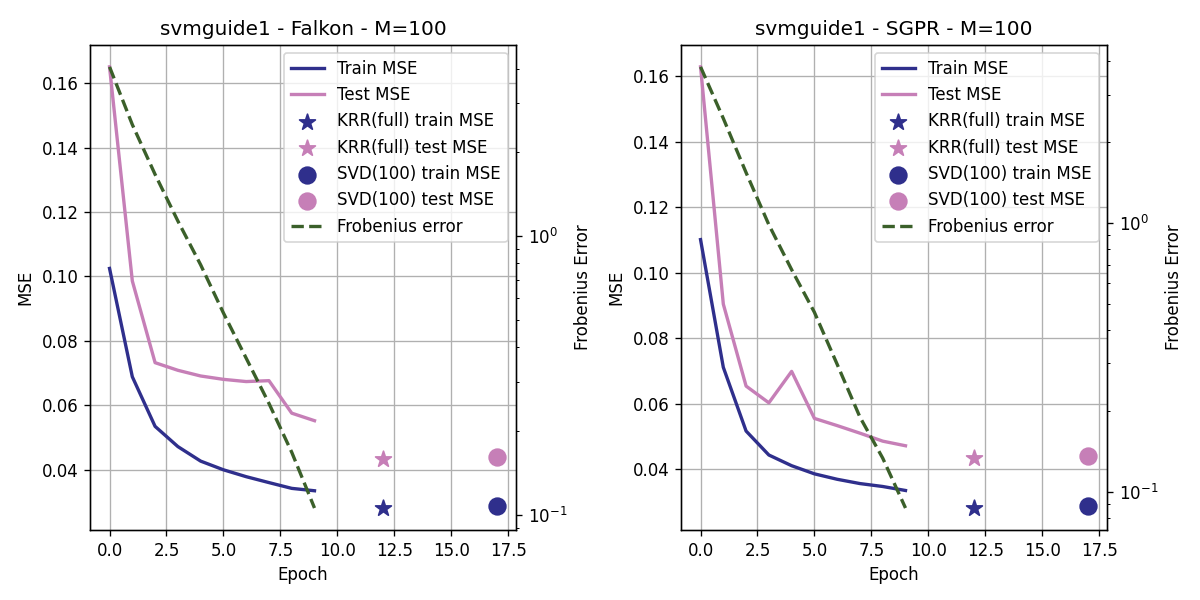

In [277]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
title = get_title("Falkon", M, train_only_trace, dset_name)
opt_plot(res_flk, M, title, figax=(fig, ax[0]))
title = get_title("SGPR", M, train_only_trace, dset_name)
opt_plot(res_sgpr, M, title, figax=(fig, ax[1]))
fig.tight_layout();

In [24]:
def sgpr_like_multidset(M, only_trace, init_penalty=10, lr=0.1, epochs=30, dsets=("cpusmall", "space_ga", "cadata", "svmguide1"), dtype=torch.float64):
    results_flk, results_sgpr = {}, {}
    for dset_name in dsets:
        Xtr, Ytr, Xts, Yts, penalty_init, sigma_init, kernel = load_dset(
            dset_name, penalty=init_penalty, dtype=dtype)
        centers_init = torch.randn(M, Xtr.shape[1], dtype=Xtr.dtype)
        res_flk = train_sgpr_like(opt_model="Falkon", penalty_init=penalty_init, sigma_init=sigma_init,
                                  centers_init=centers_init, only_trace=only_trace, lr=lr,
                                  epochs=epochs, Xtr=Xtr, Ytr=Ytr, Xts=Xts, Yts=Yts, kernel=kernel)
        res_sgpr = train_sgpr_like(opt_model="SGPR", penalty_init=penalty_init, sigma_init=sigma_init,
                                   centers_init=centers_init, only_trace=only_trace, lr=lr,
                                   epochs=epochs, Xtr=Xtr, Ytr=Ytr, Xts=Xts, Yts=Yts, kernel=kernel)
        results_flk[dset_name] = res_flk
        results_sgpr[dset_name]= res_sgpr
    return results_flk, results_sgpr
def plot_multidset(res_dict, M, only_trace):
    ncols = len(res_dict)
    key = list(res_dict.keys())[0]
    nrows = len(res_dict[key])
    
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(nrows * 2.5, ncols * 6))

    for i, (res_name, res) in enumerate(res_dict.items()):
        for j, key in enumerate(res.keys()):
            title = get_title(res_name, M, only_trace, key)
            opt_plot(res[key], M, title, figax=(fig, ax[j, i]), legend=(j==0 and i == 0))
    fig.tight_layout();
    return fig, ax

In [38]:
flk_100_l10, sgpr_100_l1 = sgpr_like_multidset(
    M=100,
    only_trace=False,
    init_penalty=1,
)

Dataset: cpusmall
torch.Size([8192, 12]) torch.Size([8192, 1])
VALUE        d_eff -5.897e+03 - loss -6.451e+03 - trace -1.930e-02. tot -1.235e+04
Epoch 0 ( 0.30s) - Sigma 8.100 - Penalty 4.07e-01 - Tr  nrmse = 0.3738 - Ts  nrmse = 0.3722
Fro err: 3.879
VALUE        d_eff -6.047e+03 - loss -6.199e+03 - trace -1.470e-02. tot -1.225e+04
Epoch 1 ( 0.69s) - Sigma 8.199 - Penalty 4.49e-01 - Tr  nrmse = 0.3927 - Ts  nrmse = 0.3913
Fro err: 3.544
VALUE        d_eff -6.200e+03 - loss -5.949e+03 - trace -1.182e-02. tot -1.215e+04
Epoch 2 ( 0.99s) - Sigma 8.298 - Penalty 4.97e-01 - Tr  nrmse = 0.4125 - Ts  nrmse = 0.4112
Fro err: 3.273
VALUE        d_eff -6.354e+03 - loss -5.701e+03 - trace -9.675e-03. tot -1.205e+04
Epoch 3 ( 1.26s) - Sigma 8.395 - Penalty 5.49e-01 - Tr  nrmse = 0.4331 - Ts  nrmse = 0.4319
Fro err: 3.026
VALUE        d_eff -6.508e+03 - loss -5.454e+03 - trace -7.972e-03. tot -1.196e+04
Epoch 4 ( 1.57s) - Sigma 8.491 - Penalty 6.06e-01 - Tr  nrmse = 0.4543 - Ts  nrmse = 0.4533
Fr

Fro err: 2.466
VALUE        d_eff -3.600e+03 - loss -1.686e+03 - trace -2.592e-03. tot -5.287e+03
Epoch 13 ( 4.04s) - Sigma 9.271 - Penalty 1.48e+00 - Tr  nrmse = 0.6565 - Ts  nrmse = 0.6559
Fro err: 2.388
VALUE        d_eff -3.649e+03 - loss -1.585e+03 - trace -2.264e-03. tot -5.234e+03
Epoch 14 ( 4.34s) - Sigma 9.343 - Penalty 1.62e+00 - Tr  nrmse = 0.6776 - Ts  nrmse = 0.6770
Fro err: 2.317
VALUE        d_eff -3.697e+03 - loss -1.488e+03 - trace -1.984e-03. tot -5.185e+03
Epoch 15 ( 4.72s) - Sigma 9.412 - Penalty 1.79e+00 - Tr  nrmse = 0.6979 - Ts  nrmse = 0.6973
Fro err: 2.253
VALUE        d_eff -3.744e+03 - loss -1.396e+03 - trace -1.744e-03. tot -5.140e+03
Epoch 16 ( 4.96s) - Sigma 9.478 - Penalty 1.96e+00 - Tr  nrmse = 0.7174 - Ts  nrmse = 0.7167
Fro err: 2.193
VALUE        d_eff -3.790e+03 - loss -1.308e+03 - trace -1.539e-03. tot -5.098e+03
Epoch 17 ( 5.20s) - Sigma 9.540 - Penalty 2.15e+00 - Tr  nrmse = 0.7359 - Ts  nrmse = 0.7352
Fro err: 2.138
VALUE        d_eff -3.836e+03 

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


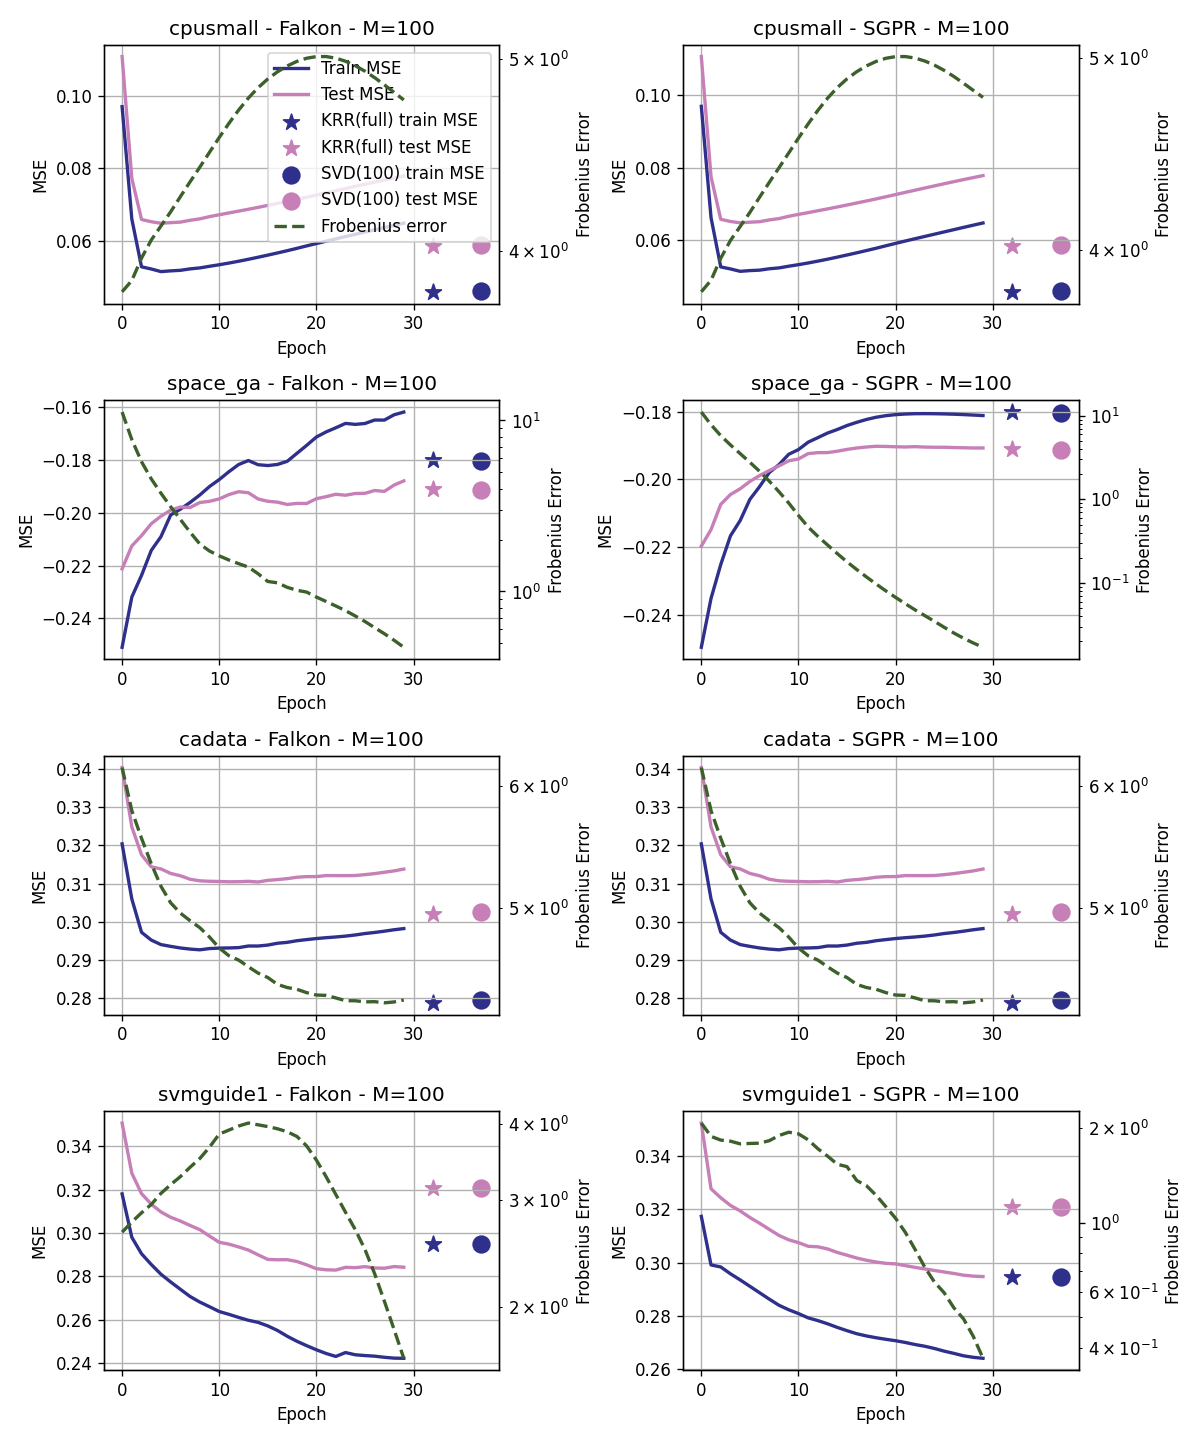

(<Figure size 1000x1200 with 16 Axes>,
 array([[<AxesSubplot:title={'center':'cpusmall - Falkon - M=100'}, xlabel='Epoch', ylabel='MSE'>,
         <AxesSubplot:title={'center':'cpusmall - SGPR - M=100'}, xlabel='Epoch', ylabel='MSE'>],
        [<AxesSubplot:title={'center':'space_ga - Falkon - M=100'}, xlabel='Epoch', ylabel='MSE'>,
         <AxesSubplot:title={'center':'space_ga - SGPR - M=100'}, xlabel='Epoch', ylabel='MSE'>],
        [<AxesSubplot:title={'center':'cadata - Falkon - M=100'}, xlabel='Epoch', ylabel='MSE'>,
         <AxesSubplot:title={'center':'cadata - SGPR - M=100'}, xlabel='Epoch', ylabel='MSE'>],
        [<AxesSubplot:title={'center':'svmguide1 - Falkon - M=100'}, xlabel='Epoch', ylabel='MSE'>,
         <AxesSubplot:title={'center':'svmguide1 - SGPR - M=100'}, xlabel='Epoch', ylabel='MSE'>]],
       dtype=object))

In [37]:
plot_multidset({"Falkon": flk_100_l10, "SGPR": sgpr_100_l10}, M=100, only_trace=False)

<IPython.core.display.Javascript object>


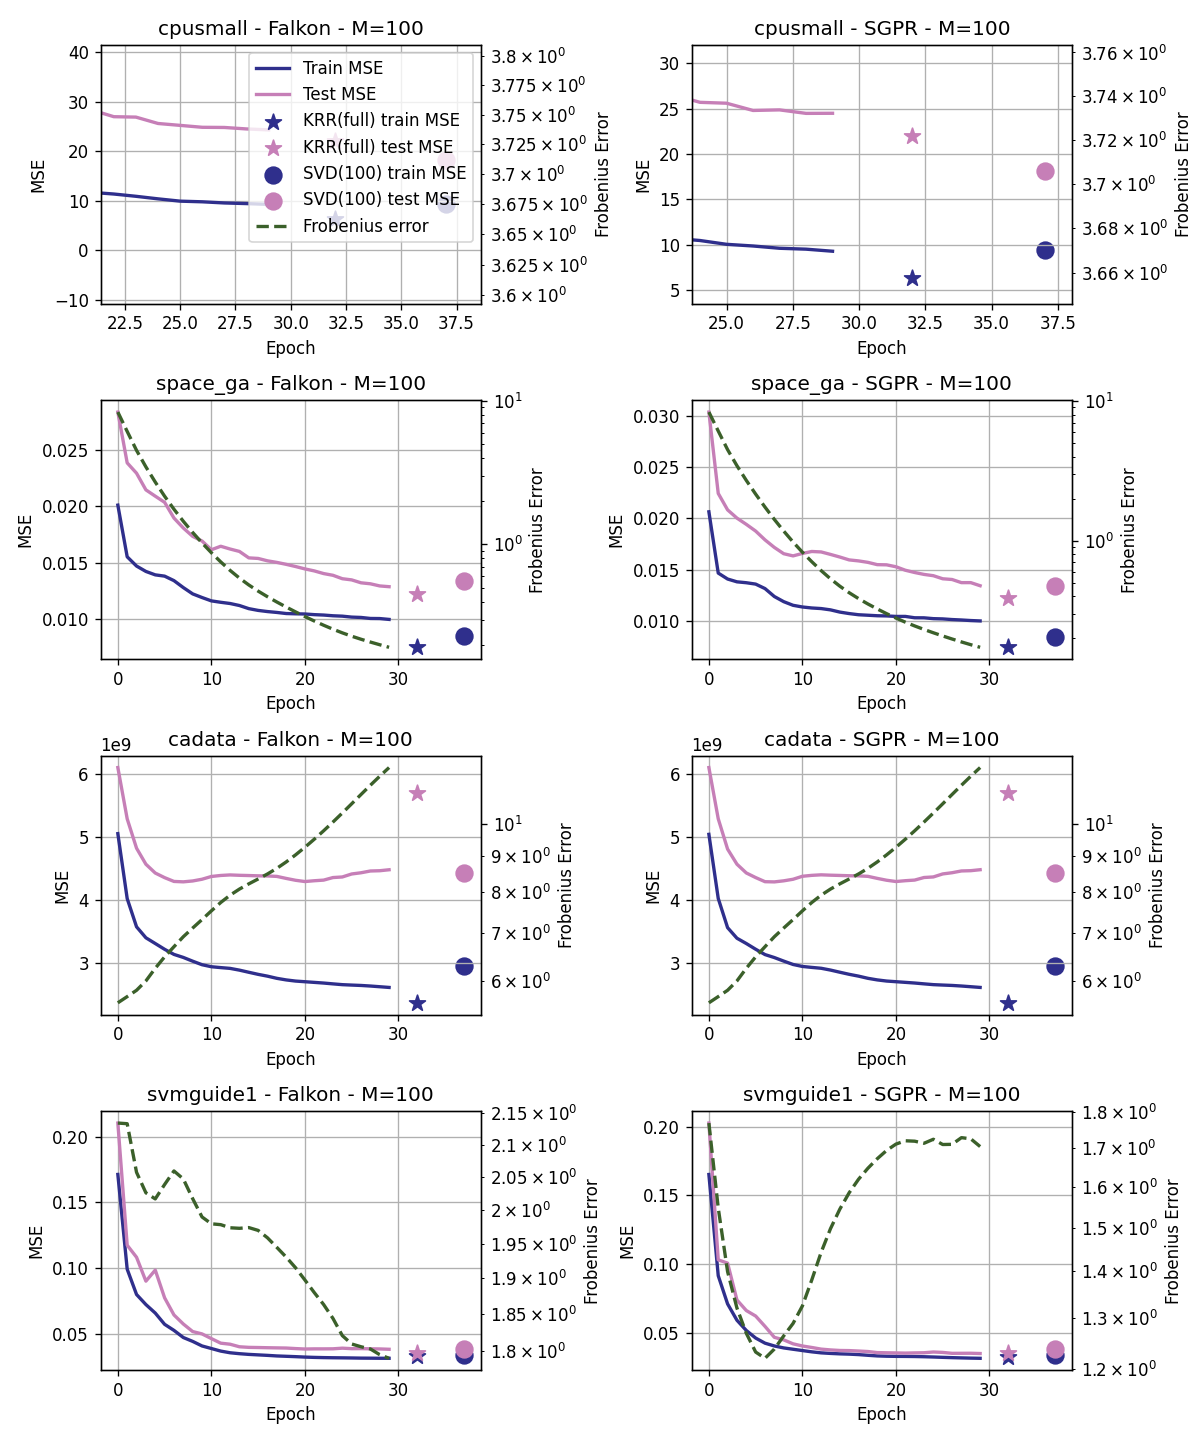

(<Figure size 1000x1200 with 16 Axes>,
 array([[<AxesSubplot:title={'center':'cpusmall - Falkon - M=100'}, xlabel='Epoch', ylabel='MSE'>,
         <AxesSubplot:title={'center':'cpusmall - SGPR - M=100'}, xlabel='Epoch', ylabel='MSE'>],
        [<AxesSubplot:title={'center':'space_ga - Falkon - M=100'}, xlabel='Epoch', ylabel='MSE'>,
         <AxesSubplot:title={'center':'space_ga - SGPR - M=100'}, xlabel='Epoch', ylabel='MSE'>],
        [<AxesSubplot:title={'center':'cadata - Falkon - M=100'}, xlabel='Epoch', ylabel='MSE'>,
         <AxesSubplot:title={'center':'cadata - SGPR - M=100'}, xlabel='Epoch', ylabel='MSE'>],
        [<AxesSubplot:title={'center':'svmguide1 - Falkon - M=100'}, xlabel='Epoch', ylabel='MSE'>,
         <AxesSubplot:title={'center':'svmguide1 - SGPR - M=100'}, xlabel='Epoch', ylabel='MSE'>]],
       dtype=object))

In [33]:
plot_multidset({"Falkon": flk_100, "SGPR": sgpr_100}, M=100, only_trace=False)

<IPython.core.display.Javascript object>


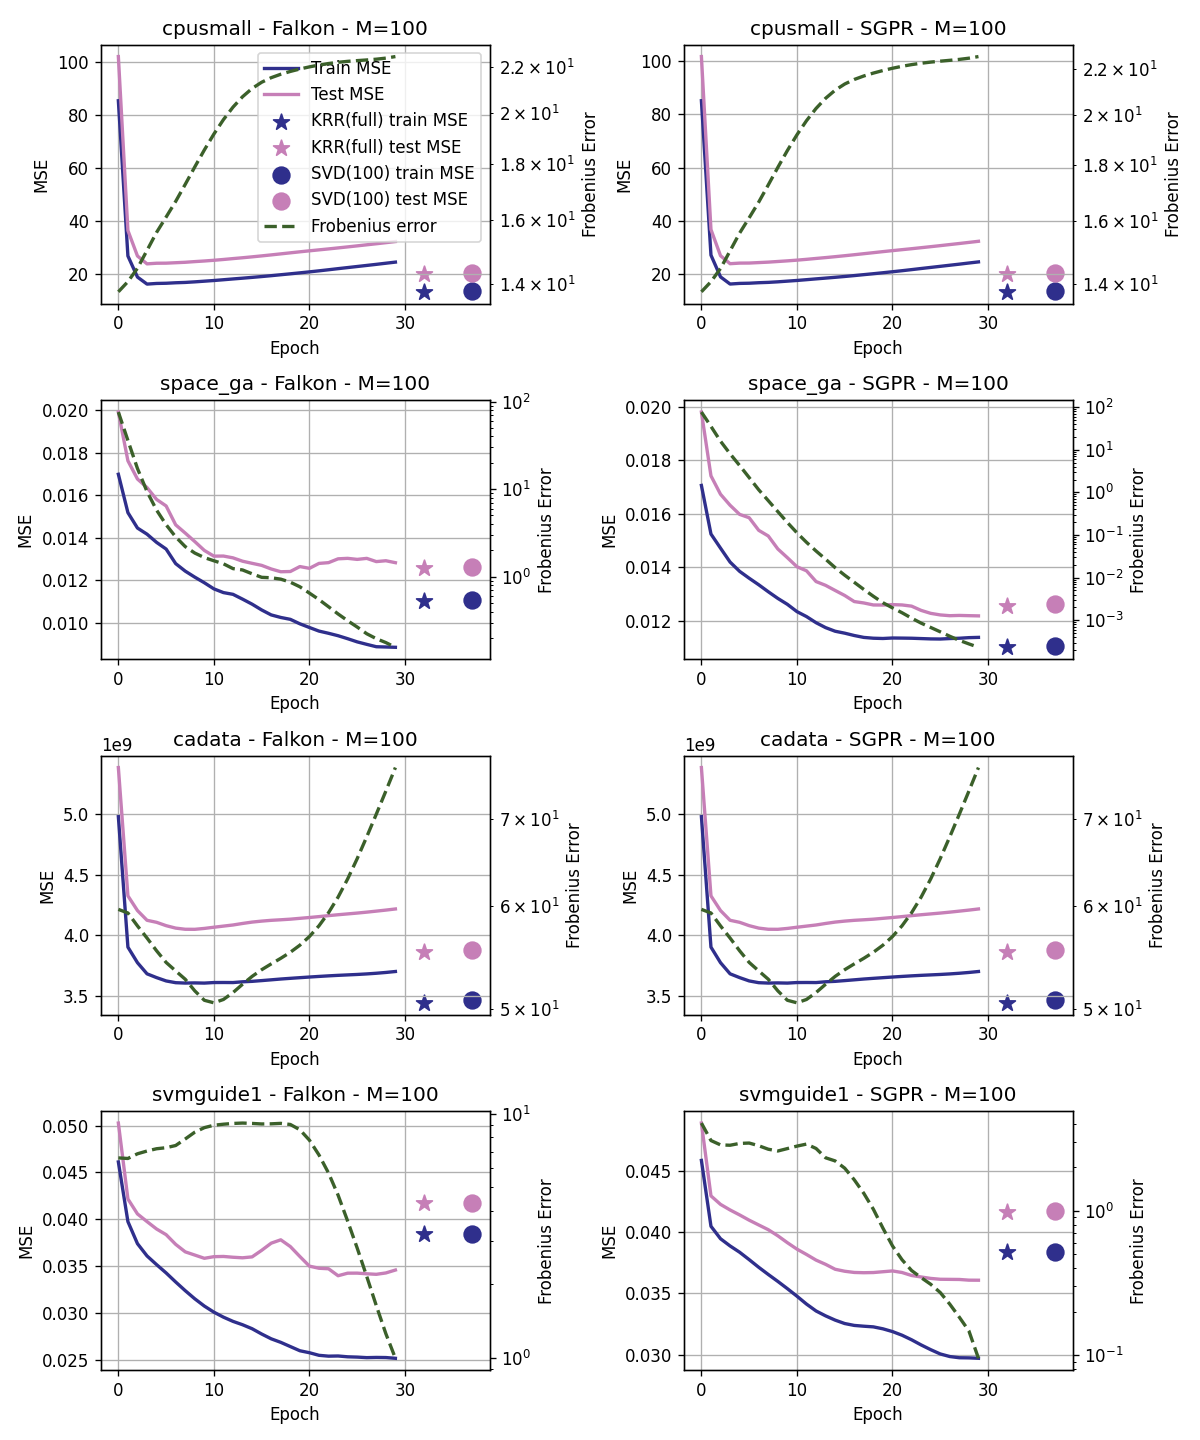

In [31]:
results_flk = results_100_flk
results_sgpr = results_100_sgpr
M = 100
fig, ax = plt.subplots(nrows=len(results_flk), ncols=2, figsize=(10, 12))

for i, key in enumerate(results_flk.keys()):
    title_flk = get_title("Falkon", M, train_only_trace, key)
    opt_plot(results_flk[key], M, title_flk, figax=(fig, ax[i,0]), legend=(i==0))
    
    title_sgpr = get_title("SGPR", M, train_only_trace, key)
    opt_plot(results_sgpr[key], M, title_sgpr, figax=(fig, ax[i,1]), legend=False)
fig.tight_layout();

<IPython.core.display.Javascript object>


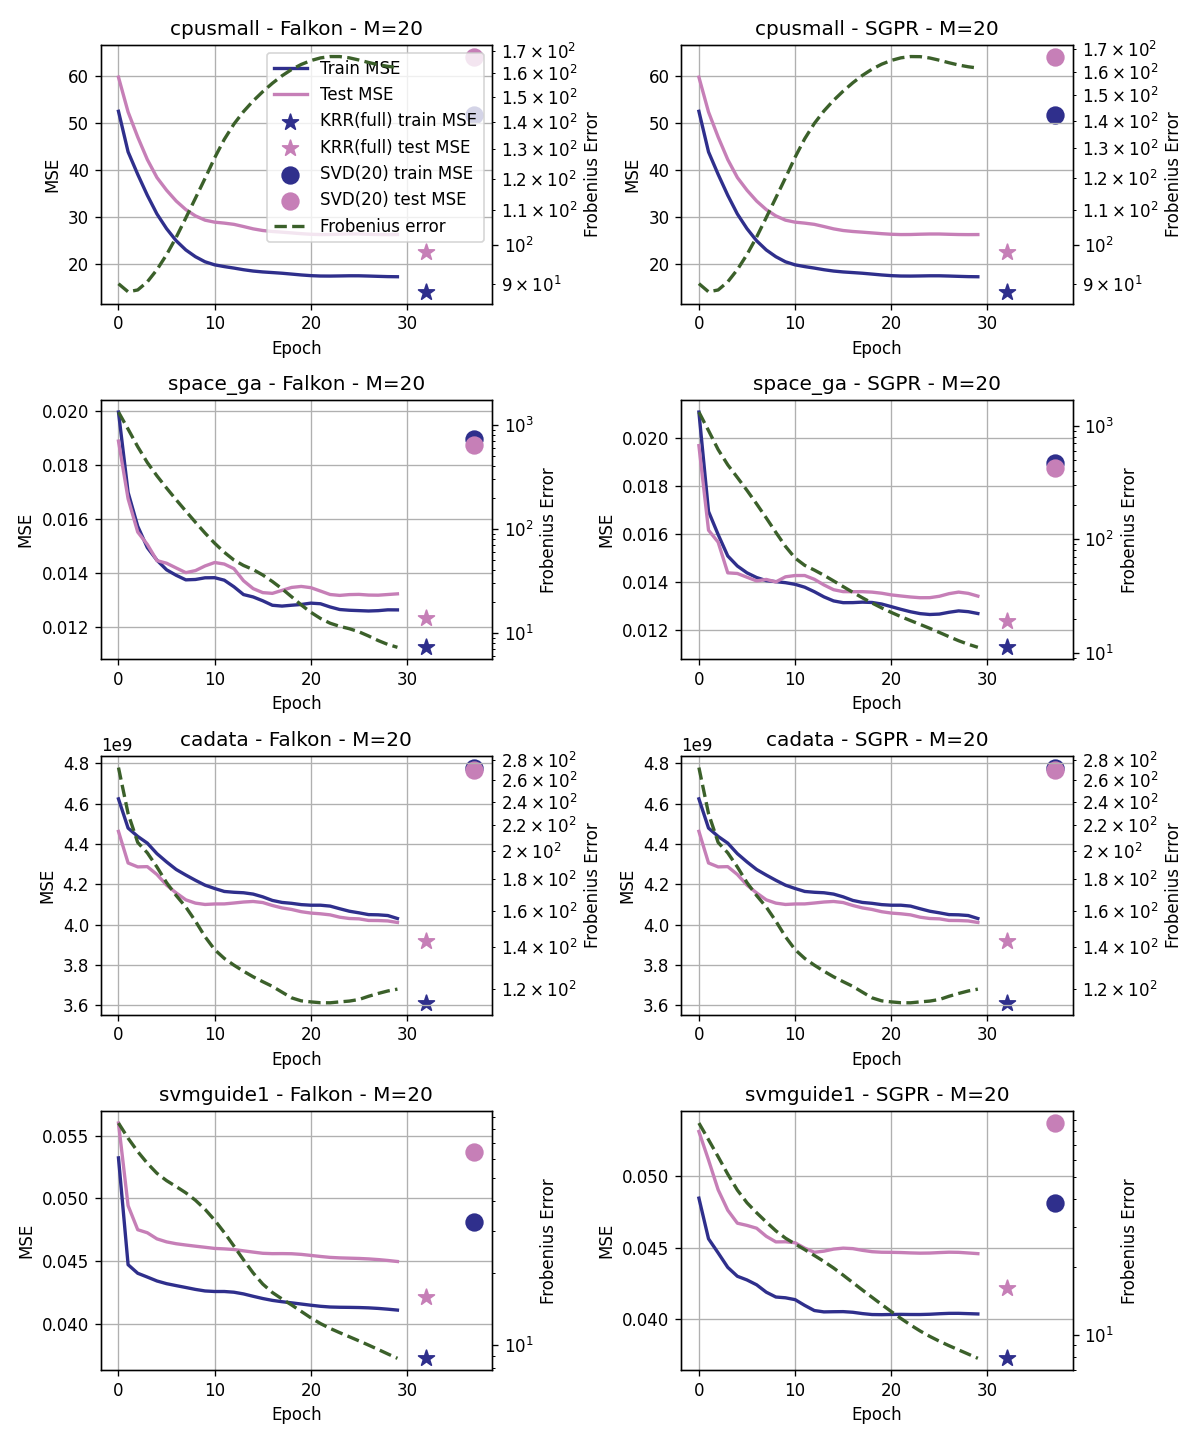

In [22]:
results_flk = results_20_flk
results_sgpr = results_20_sgpr
M = 20
fig, ax = plt.subplots(nrows=len(results_flk), ncols=2, figsize=(10, 12))

for i, key in enumerate(results_flk.keys()):
    title_flk = get_title("Falkon", M, train_only_trace, key)
    opt_plot(results_flk[key], M, title_flk, figax=(fig, ax[i,0]), legend=(i==0))
    
    title_sgpr = get_title("SGPR", M, train_only_trace, key)
    opt_plot(results_sgpr[key], M, title_sgpr, figax=(fig, ax[i,1]), legend=False)

fig.tight_layout();